#Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)

**Luis Ángel Cruz García A01736345**

##Introducción
En este proyecto se implementarán herramientas que son de gran utilidad para el análisis de grandes cantidades de información, específicamente, se utilizará PySpark para hacer la carga de datos, el modelado para obtener una predicción y su posterior evaluación. Por otra parte, Tableau será el software encargado de hacer las gráficas necesarias para permitir un mejor entendimiento de los datos y, por consiguiente, una mejor capacidad de explicación.

En este caso, es importante mencionar que el dataset elegido fue obtenido de Kaggle:
https://www.kaggle.com/datasets/patrickfleith/dynamical-system-multivariate-time-series-forecast/data

Este dataset cuenta con la característica de pesar 1.43 GB, además de que son datos numéricos, lo que brinda una mayor posibilidad de análisis.

La información de mayor utilidad que nos es brindada es la siguiente:

* El conjunto de datos DSMTS es una serie temporal multivariada que simula el comportamiento de un sistema dinámico complejo bajo condiciones normales, poco anómalas.

* Incluye 17 variables (4 comandos de control, 3 estímulos ambientales y 10 lecturas de telemetría). Siendo en total 5 millones de puntos de tiempo, con lecturas a 1Hz.






##Entorno de PySpark y conexión con Google Colab
En este caso se utilizará la versión 3.4.4 de Spark.


In [ ]:
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 4s (104 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not see

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Variables de entorno de Java y Spark:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

##Sesión de Spark
Sesión de Spark para poder contar con las capacidades de procesamiento distribuido de PySpark.

Nombre: PySparkLR

 Memoria RAM del executor: 3g

 Memoria RAM del driver: 3g

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySparkLR").config("spark.executor.memory", "3g").config("spark.driver.memory", "3g").getOrCreate()


##Carga de datos
El dataset es cargado desde Google Drive y es almacenado en un DataFrame de Spark, decidí utilizar esta estructura debido a que divide automáticamente los datos y las operaciones entre los nodos del clúster, lo que permite procesar datos de forma paralela y mejorar la velocidad de ejecución. Además, al contar con datos estructurados, que pueden cambiar y que podrían ser manipulados en diferentes ocasiones, el Dataframe resulta mejor para este caso que otras estructuras como el RDD.

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/TC3006C-InteligenciaAritificialAvanzada/PySpark project/data.csv", header=True, inferSchema=True)
data.show(5)

+-------------------+----+----+------------------+--------------------+--------------------+----+----+----+----+----+--------------------+--------------------+----+----+----+--------------------+--------------------+
|          timestamp|aimp|amud|              arnd|               asin1|               asin2|adbr|adfl|bed1|bed2|bfo1|                bfo2|                bso1|bso2|bso3|ced1|                cfo1|                cso1|
+-------------------+----+----+------------------+--------------------+--------------------+----+----+----+----+----+--------------------+--------------------+----+----+----+--------------------+--------------------+
|2023-01-01 00:00:00| 0.0| 1.0|              20.0|                 0.0|                 0.0| 0.0| 0.0| 0.0| 0.0| 0.0|                 0.0|                 0.0| 0.0| 0.0| 0.0|                 0.0|                 0.0|
|2023-01-01 00:00:01| 0.0| 1.0|20.080031441673444|1.999999999866666...|1.999999986666667E-4| 0.0| 0.0| 0.0| 0.0| 0.0|4.9939115014180

##Análisis y preparado de datos
Primeramente se muestra la cantidad de datos para verificar la información brindada al inicio.



In [ ]:
# Obtener el número de filas y columnas
num_rows = data.count()
num_cols = len(data.columns)

print(f"Número de filas: {num_rows}")
print(f"Número de columnas: {num_cols}")

Número de filas: 5000000
Número de columnas: 18


Se buscan valores nulos o infinitos

In [ ]:
from pyspark.sql.functions import col, isnan, when, count, lit

# Cuenta los valores NaN y nulos en cada columna
data.select([
    count(when((isnan(c) | col(c).isNull()) if dict(data.dtypes)[c] in ['double', 'float'] else col(c).isNull(), c)).alias(c)
    for c in data.columns
]).show()

# Cuenta los valores infinitos en cada columna
data.select([
    count(when((col(c) == float('inf')) | (col(c) == float('-inf')), c)).alias(c)
    if dict(data.dtypes)[c] in ['double', 'float'] else lit(0).alias(c)
    for c in data.columns
]).show()

+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+
|timestamp|aimp|amud|arnd|asin1|asin2|adbr|adfl|bed1|bed2|bfo1|bfo2|bso1|bso2|bso3|ced1|cfo1|cso1|
+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+
|        0|   0|   0|   0|    0|    0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+

+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+
|timestamp|aimp|amud|arnd|asin1|asin2|adbr|adfl|bed1|bed2|bfo1|bfo2|bso1|bso2|bso3|ced1|cfo1|cso1|
+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+
|        0|   0|   0|   0|    0|    0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+---------+----+----+----+-----+-----+----+----+----+----+----+----+----+----+----+----+----+----+



In [ ]:
# Mostrar estadísticas descriptivas de las columnas numéricas
data.describe().show()

+-------+-------------------+-----------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+
|summary|               aimp|             amud|              arnd|               asin1|               asin2|               adbr|               adfl|              bed1|               bed2|              bfo1|              bfo2|               bso1|               bso2|               bso3|              ced1|              cfo1|               cso1|
+-------+-------------------+-----------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+--------

##Gráficas iniciales
A continuación, se muestran gráficas de distribución de los datos, principalmente de las lecturas de telimetría.

Estas gráficas son histogramas que son obtenidas haciendo uso de la separación automática de bin o contenedores en Tableau para aprovechar de mejor manera dicha herramienta, esta es una función que agrupa los datos en intervalos definidos automáticamente para facilitar el análisis en gráficos. Tableau evalúa los valores numéricos y su distribución, y luego genera rangos de tamaño uniforme, llamados bins, para que se pueda ver la frecuencia de datos en cada intervalo. Esto ayuda a visualizar la distribución y patrones de los datos sin necesidad de especificar manualmente el tamaño o número de bins.

El proceso para realizarlas fue importar el dataset a Tableu, después, fui utilizando las variables y operaciones correspondientes para poder ver los datos de manera correcta, además de evaluar qué tipo de gráfica era la requerida para entender mejor dichos datos.



###Gráfica Adbr
En la siguiente gráfica vemos una de las variables que son definidas como comandos de control en el dataset, y como se puede observar, existen solo dos estados, por lo tanto, podrán ser tomados como variables categóricas, lo que se utilizará one hot encoding para lograr un mejor resultado. En la gráfica se puede observar que existe una distribución casi igual entre ambas clases.

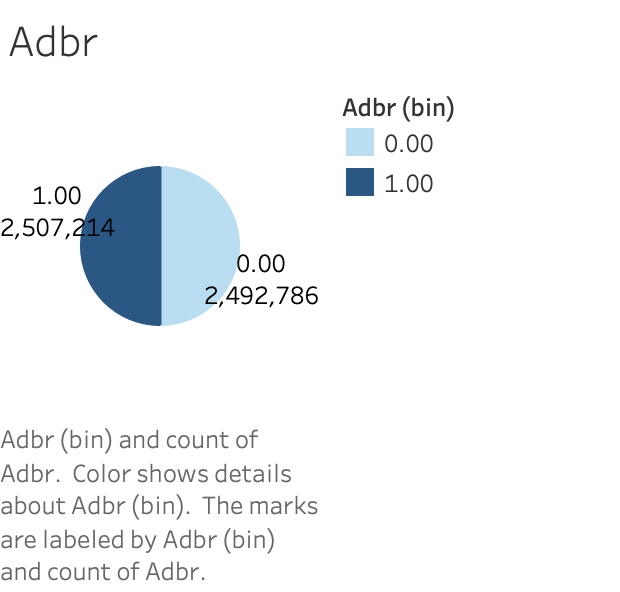

####One hot encoding

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Indexación de la columna 'adbr'
indexer = StringIndexer(inputCol="adbr", outputCol="adbrIndex")
model = indexer.fit(data)
indexed = model.transform(data)

# Codificación One-Hot de la columna 'adbrIndex'
encoder = OneHotEncoder(inputCols=["adbrIndex"], outputCols=["adbrVec"])
encoded = encoder.fit(indexed).transform(indexed)

# Definir las columnas de características, excluyendo 'timestamp' y 'adbr'
feature_cols = ["adbrVec"] + [col for col in data.columns if col not in ["adbr", "timestamp"]]

# Usar el DataFrame 'encoded' en el VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(encoded)


###Gráfica Bed1
Enn esta gráfica se puede observar que existe una distribución en la que los valores se encuentran principalmente entre 0 y 1.5, para después ir decrementando. Se muestran valores distribuidos que si bien no completan una forma normal, no muestran anomalías como outliers.

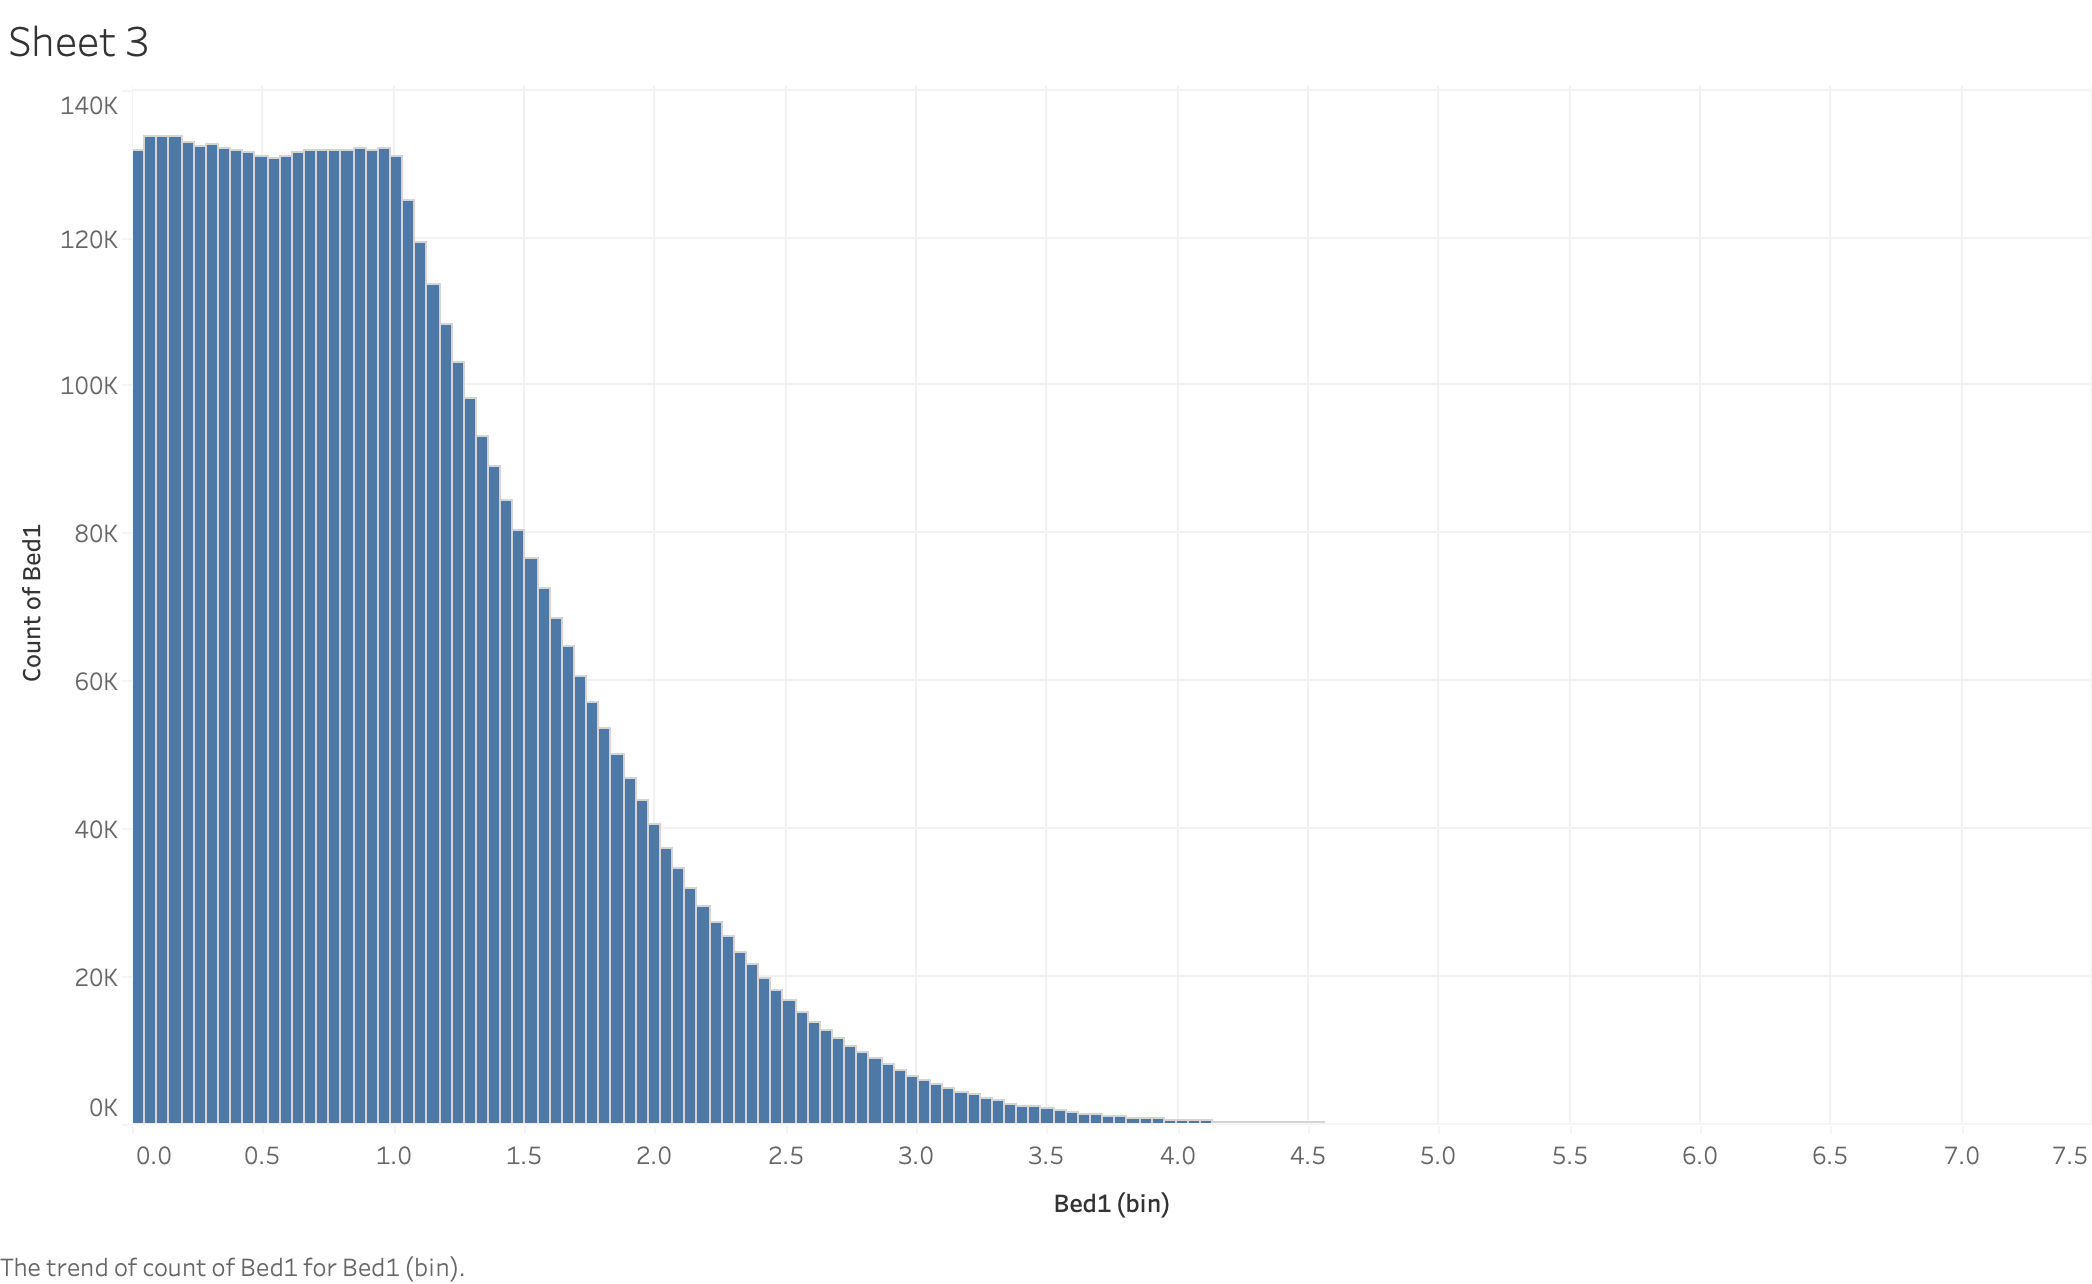

###Gráfica Bed2
Enn esta gráfica se puede observar que existe una distribución en la que una cantidad mucho mayor de datos tienen un valor igual a 0, esto es importante a mencionar ya que en ciertas ocasiones buscamos eliminar valores como el 0, sin embargo, en este caso terminaríamos por quitar muchos datos.

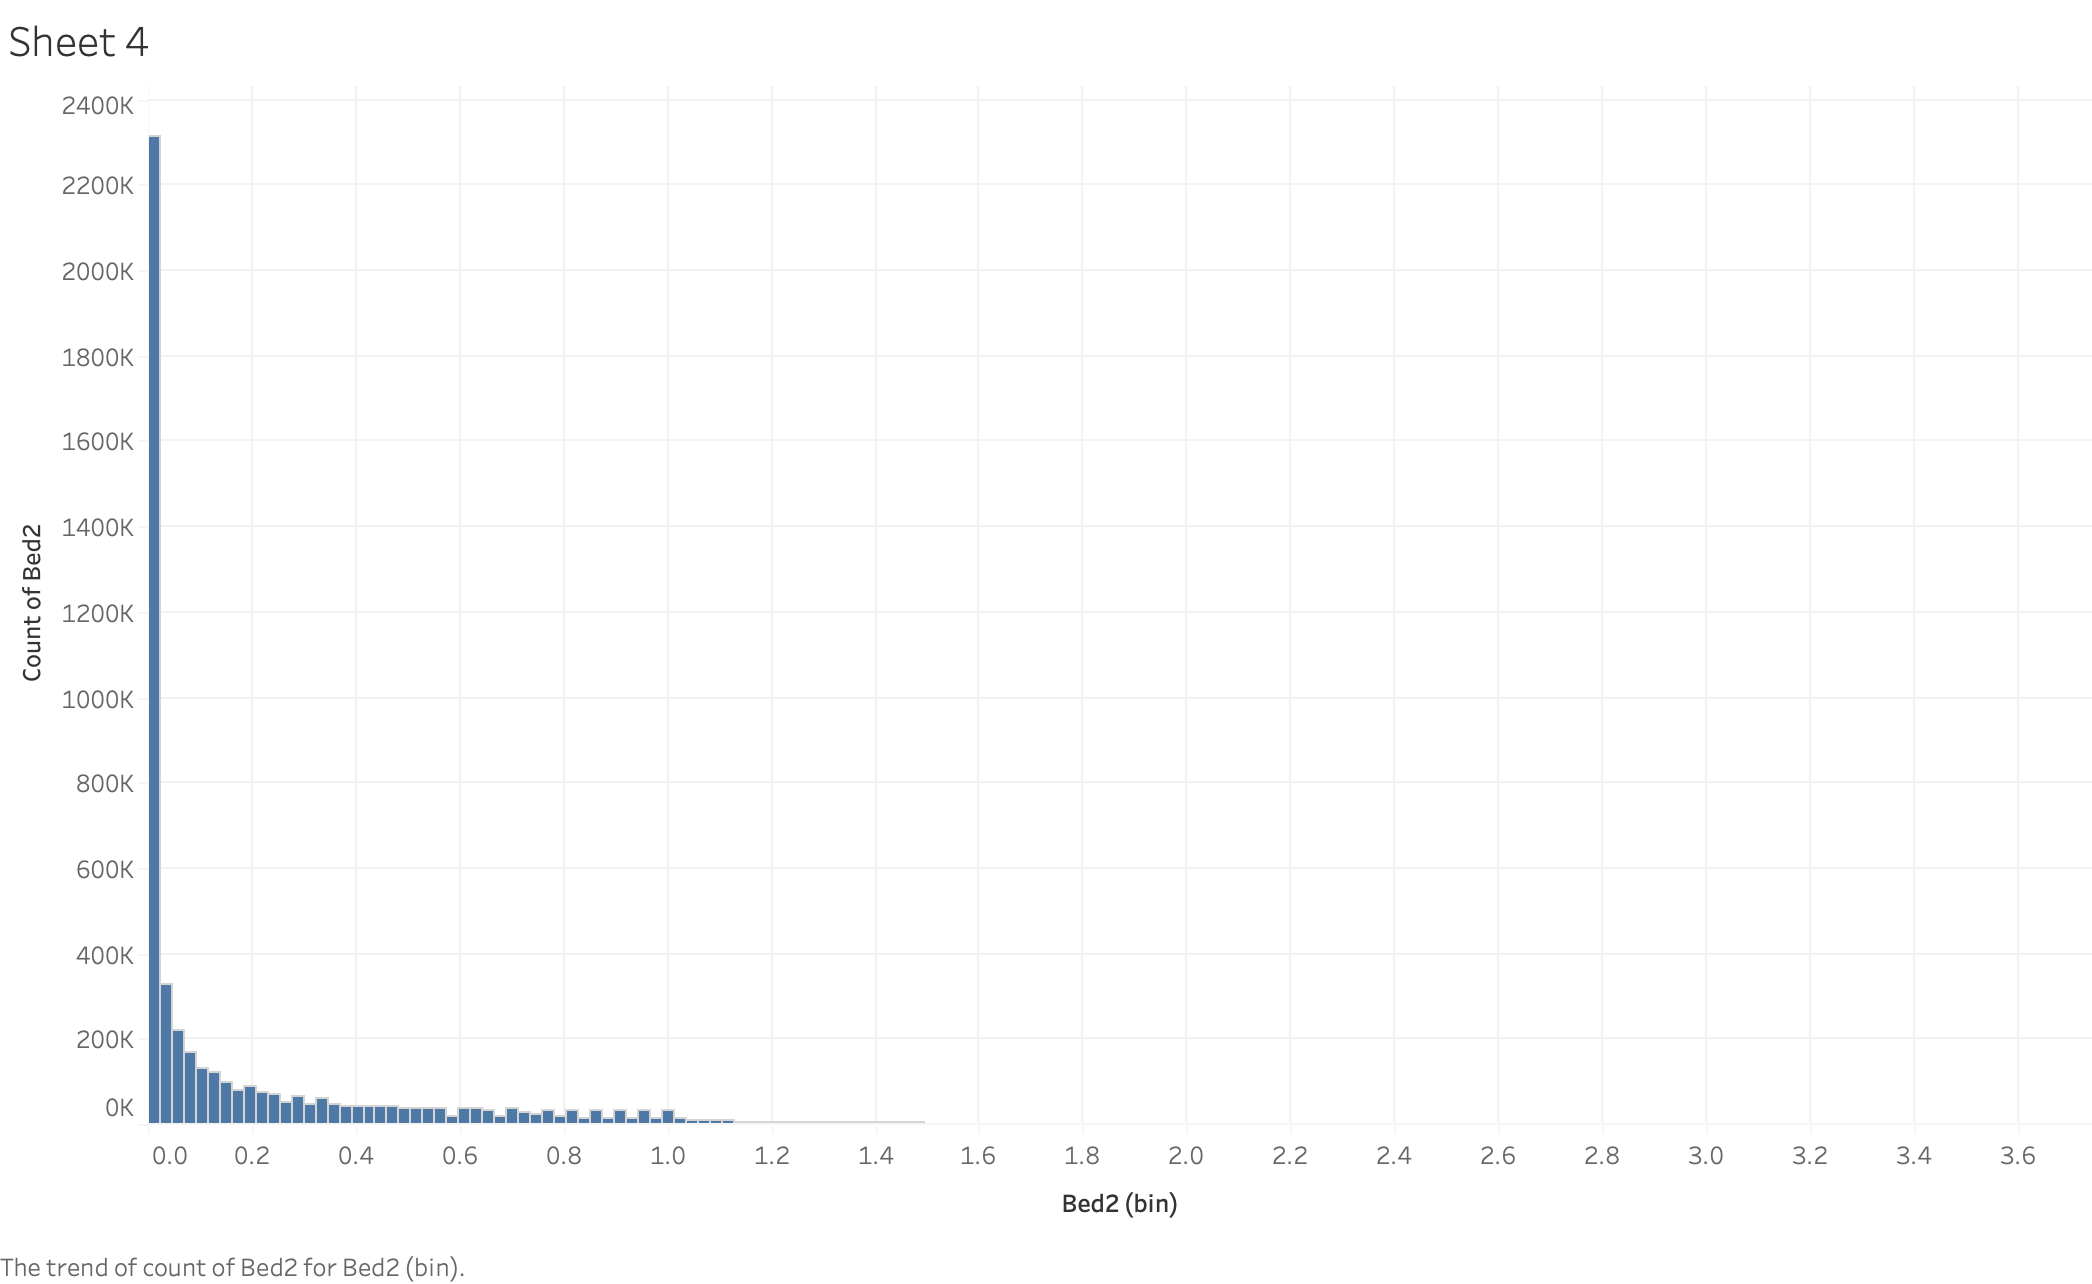

###Gráfica Bfo1
Al igual que en la gráfica anterior, se muestran una gran cantidad de datos con valor igual a 0, por otra parte, si se apreciara de manera aislada, se podría apreciar una distribución normal con un pico en el valor 10.

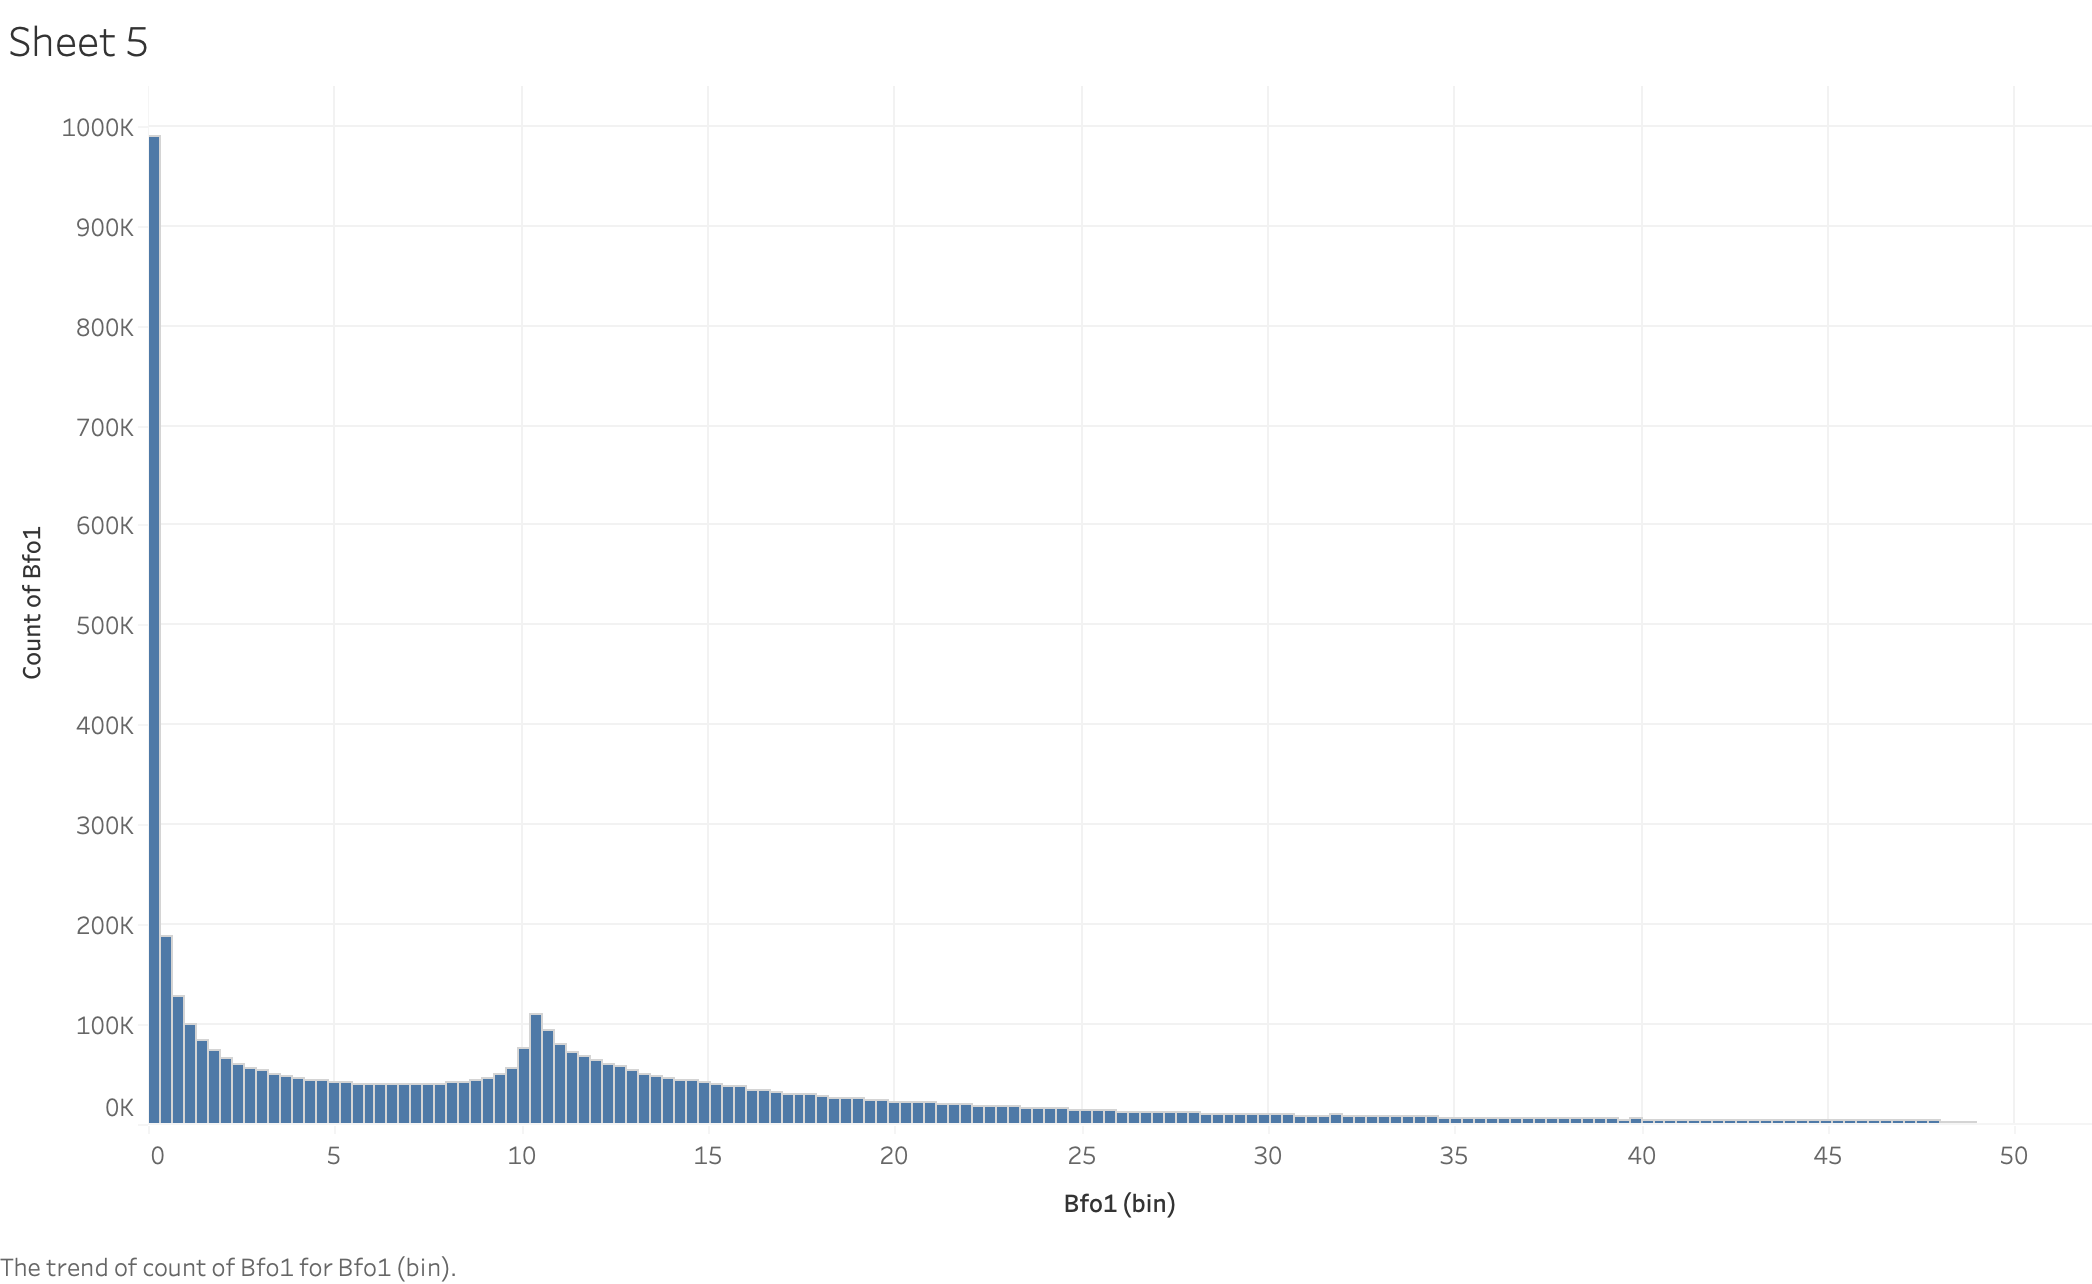

###Gráfica Bfo2
La gráfica muestra una distribución normal, por lo que los valores pueden ser ingresados al modelo sin necesidad de modificarlos.

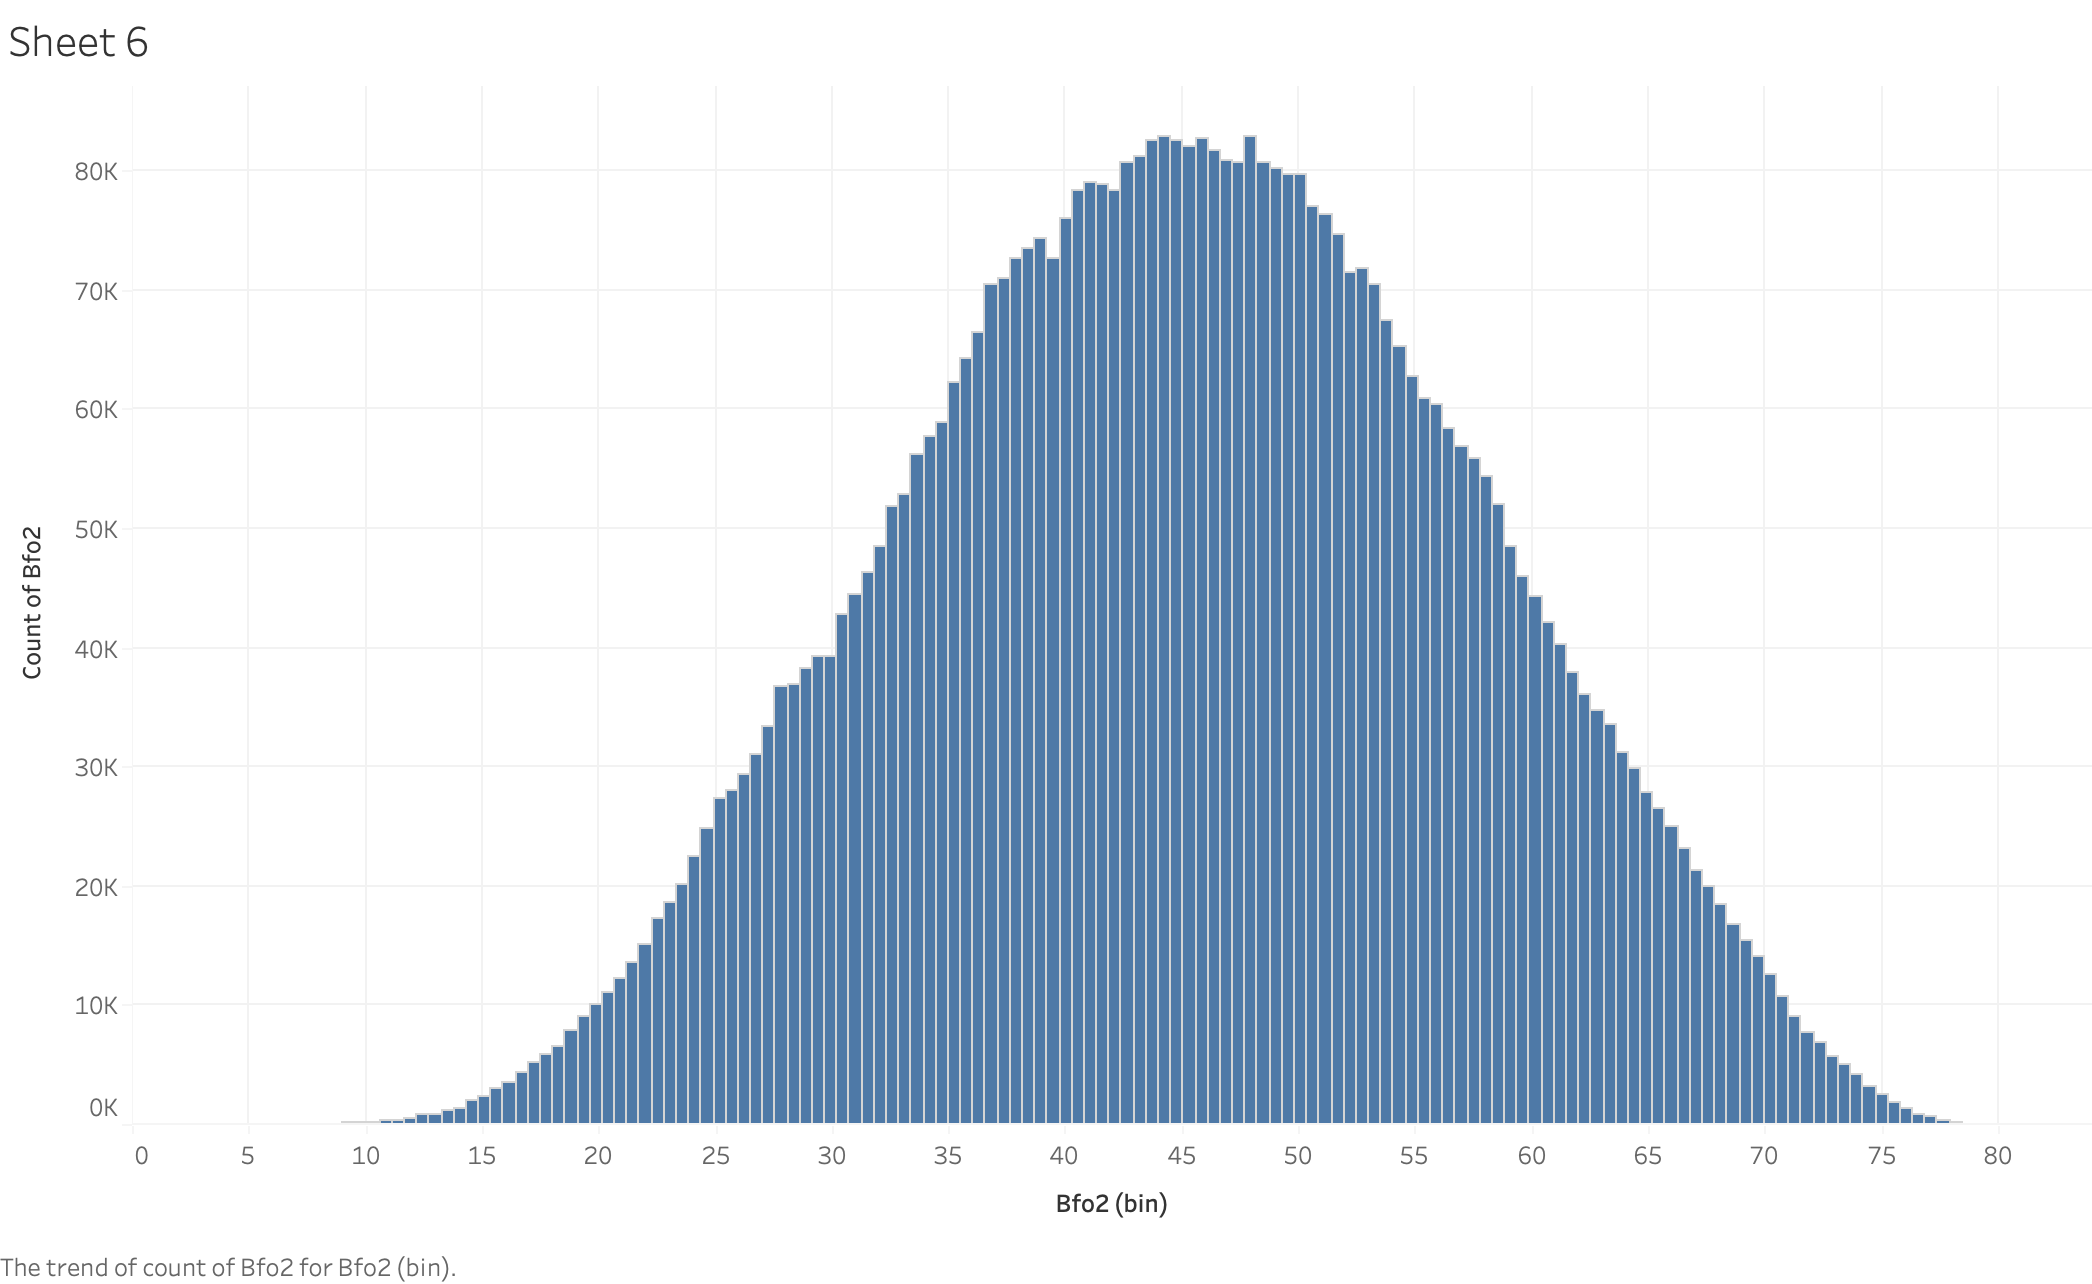

###Gráfica Bso1
La gráfica muestra una distribución normal, que si bien no resulta tan definida como la anterior, si lo es lo suficiente como para que sea considerada de esta forma en el tratamiento de datos.

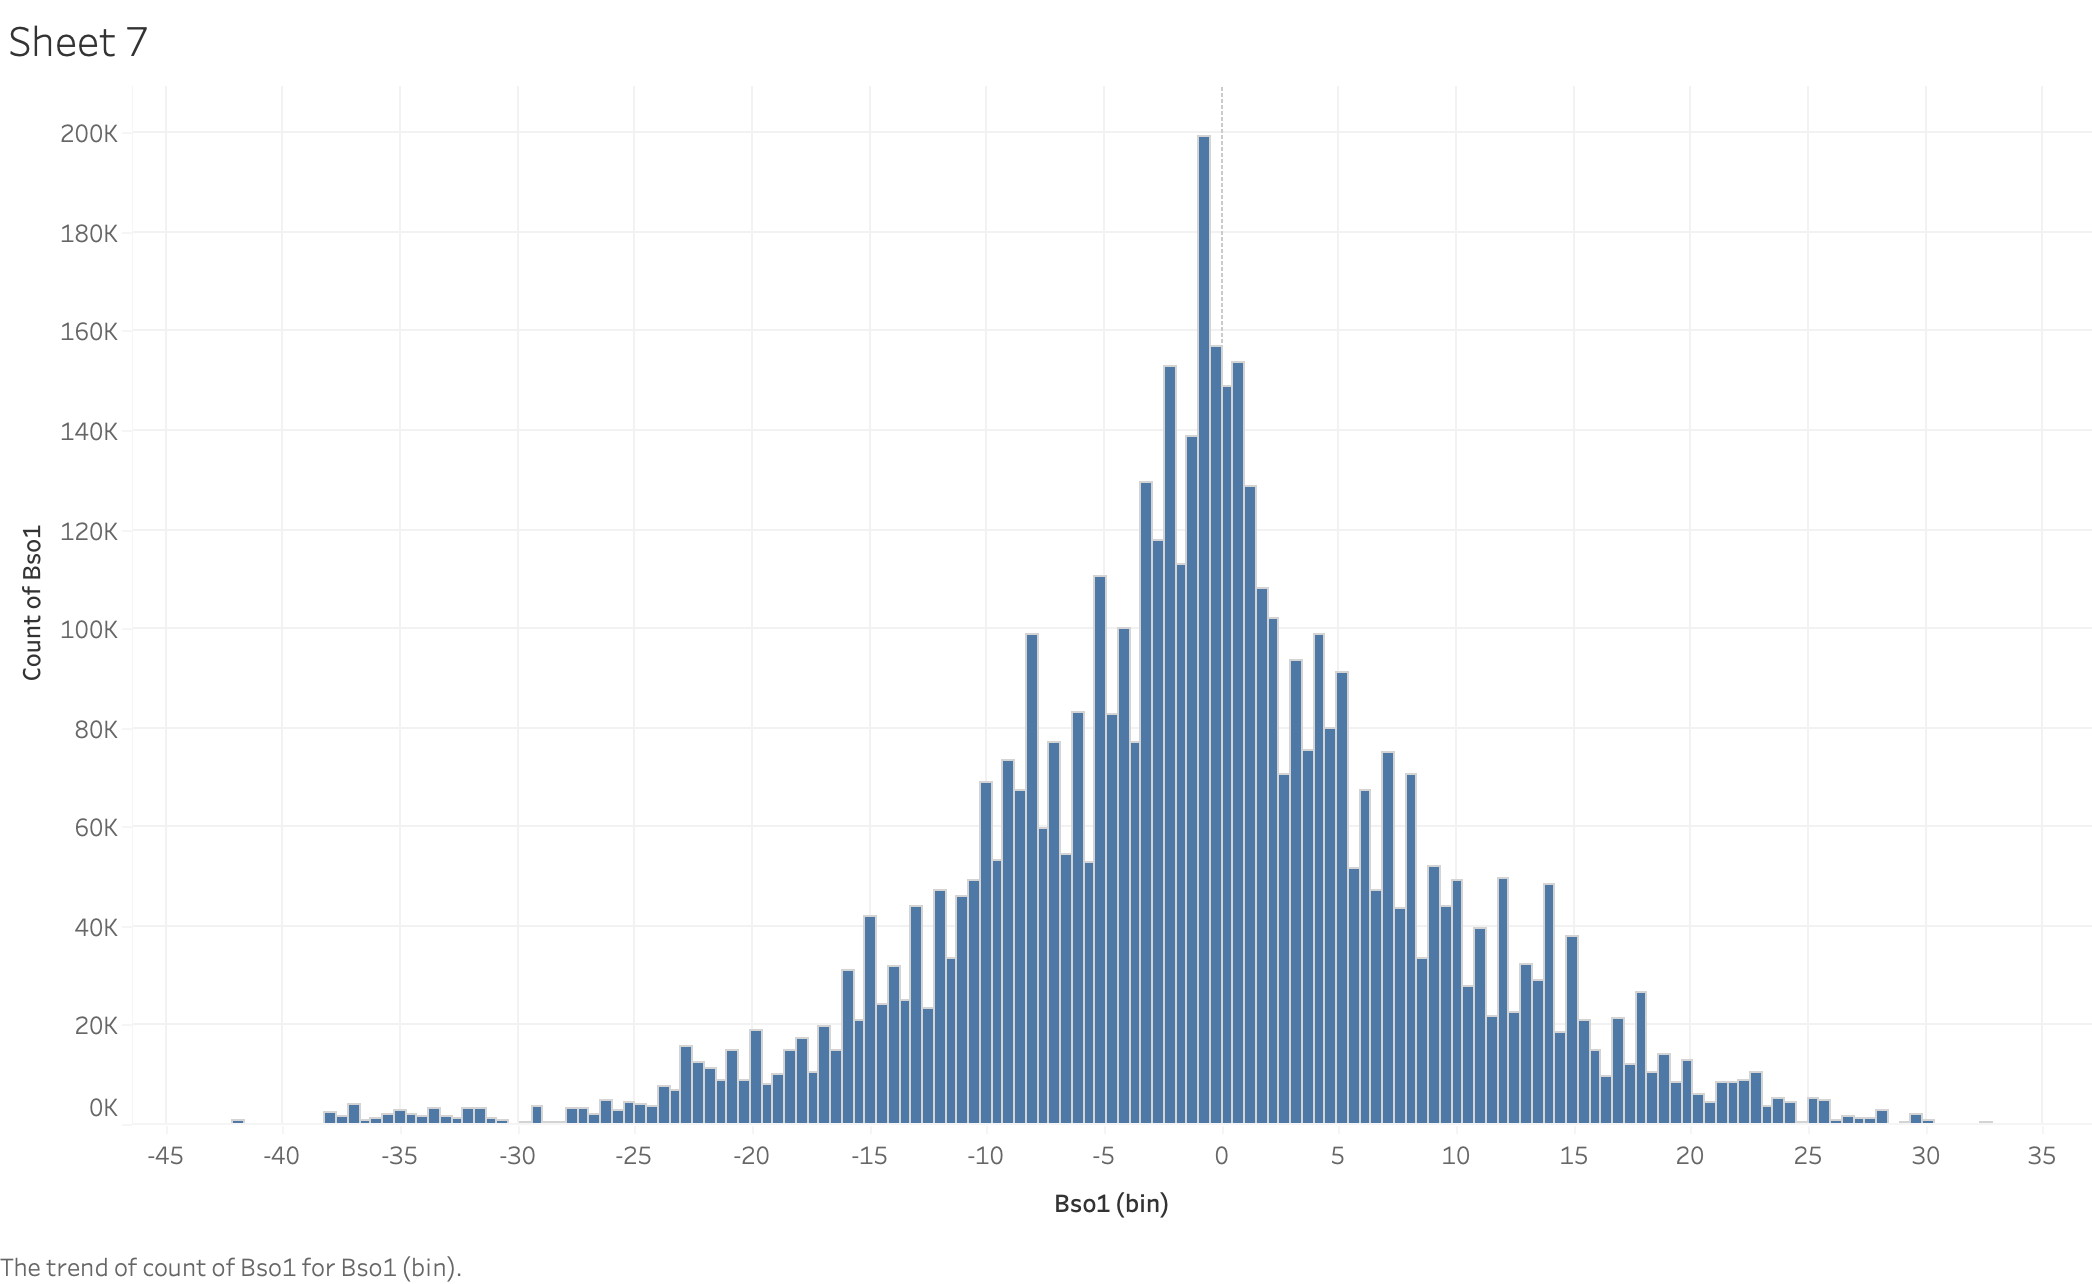

###Gráfica Bso2
La distribución muestra varios picos y valles, indicando que los valores no se distribuyen de forma uniforme como si pasaba en imágenes anteriores. Hay una acumulación considerable de datos en dos regiones específicas (alrededor de 0.7 y entre -0.7 y -0.4), lo que sugiere que la variable tiene grupos o concentraciones en esos intervalos. Esto podría indicar que los datos presentan una tendencia o patrón específico.

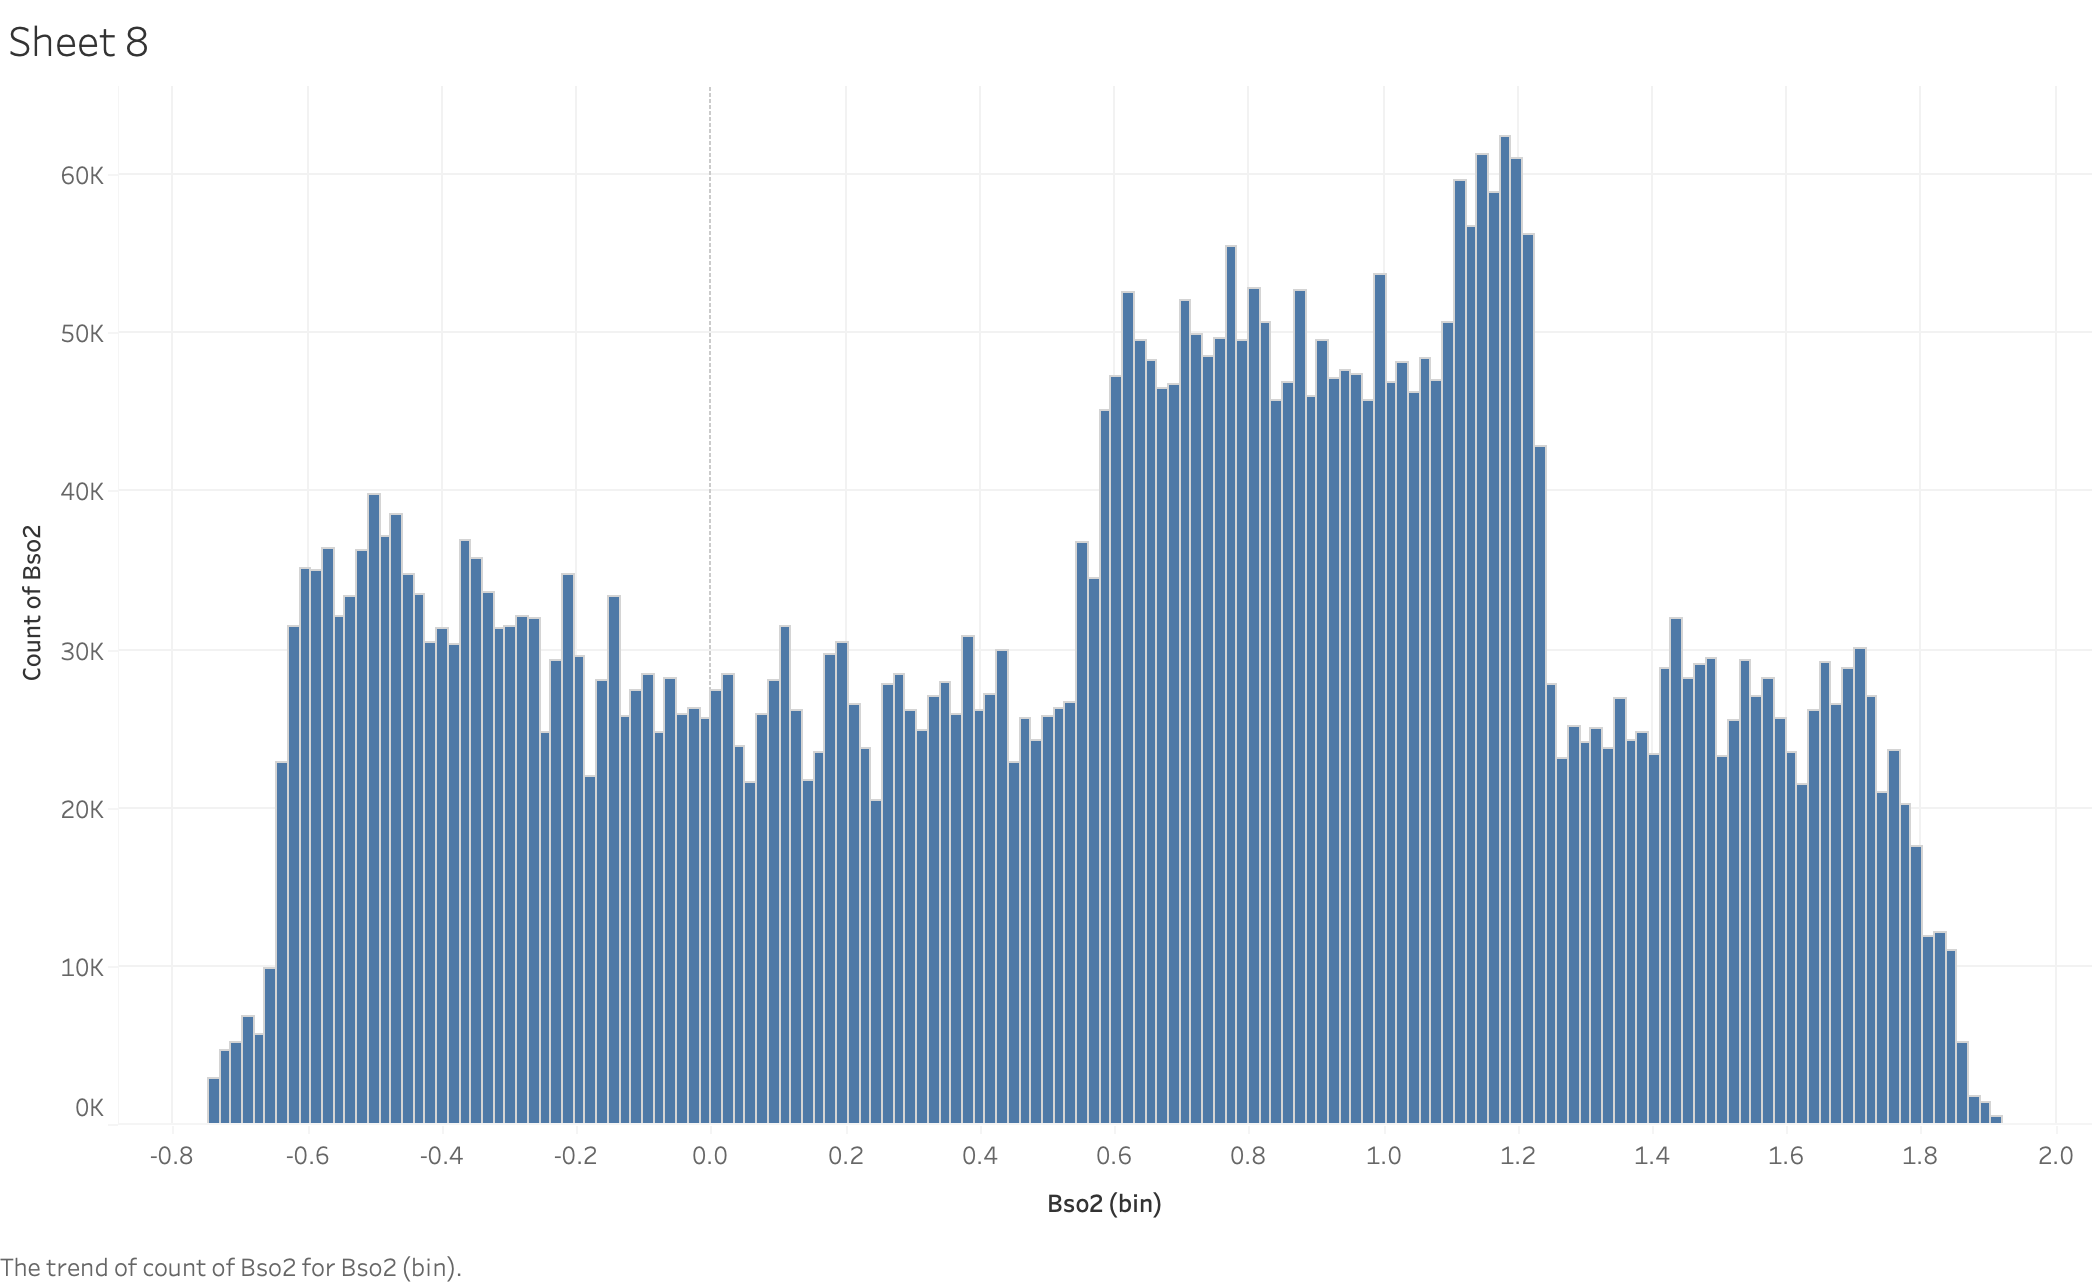

###Gráfica Bso3
Al igual que en los datos Bfo2, se muestra una distribución normal muy definida, con la diferencia que los valores en este caso son mucho menores, siendo decimales.

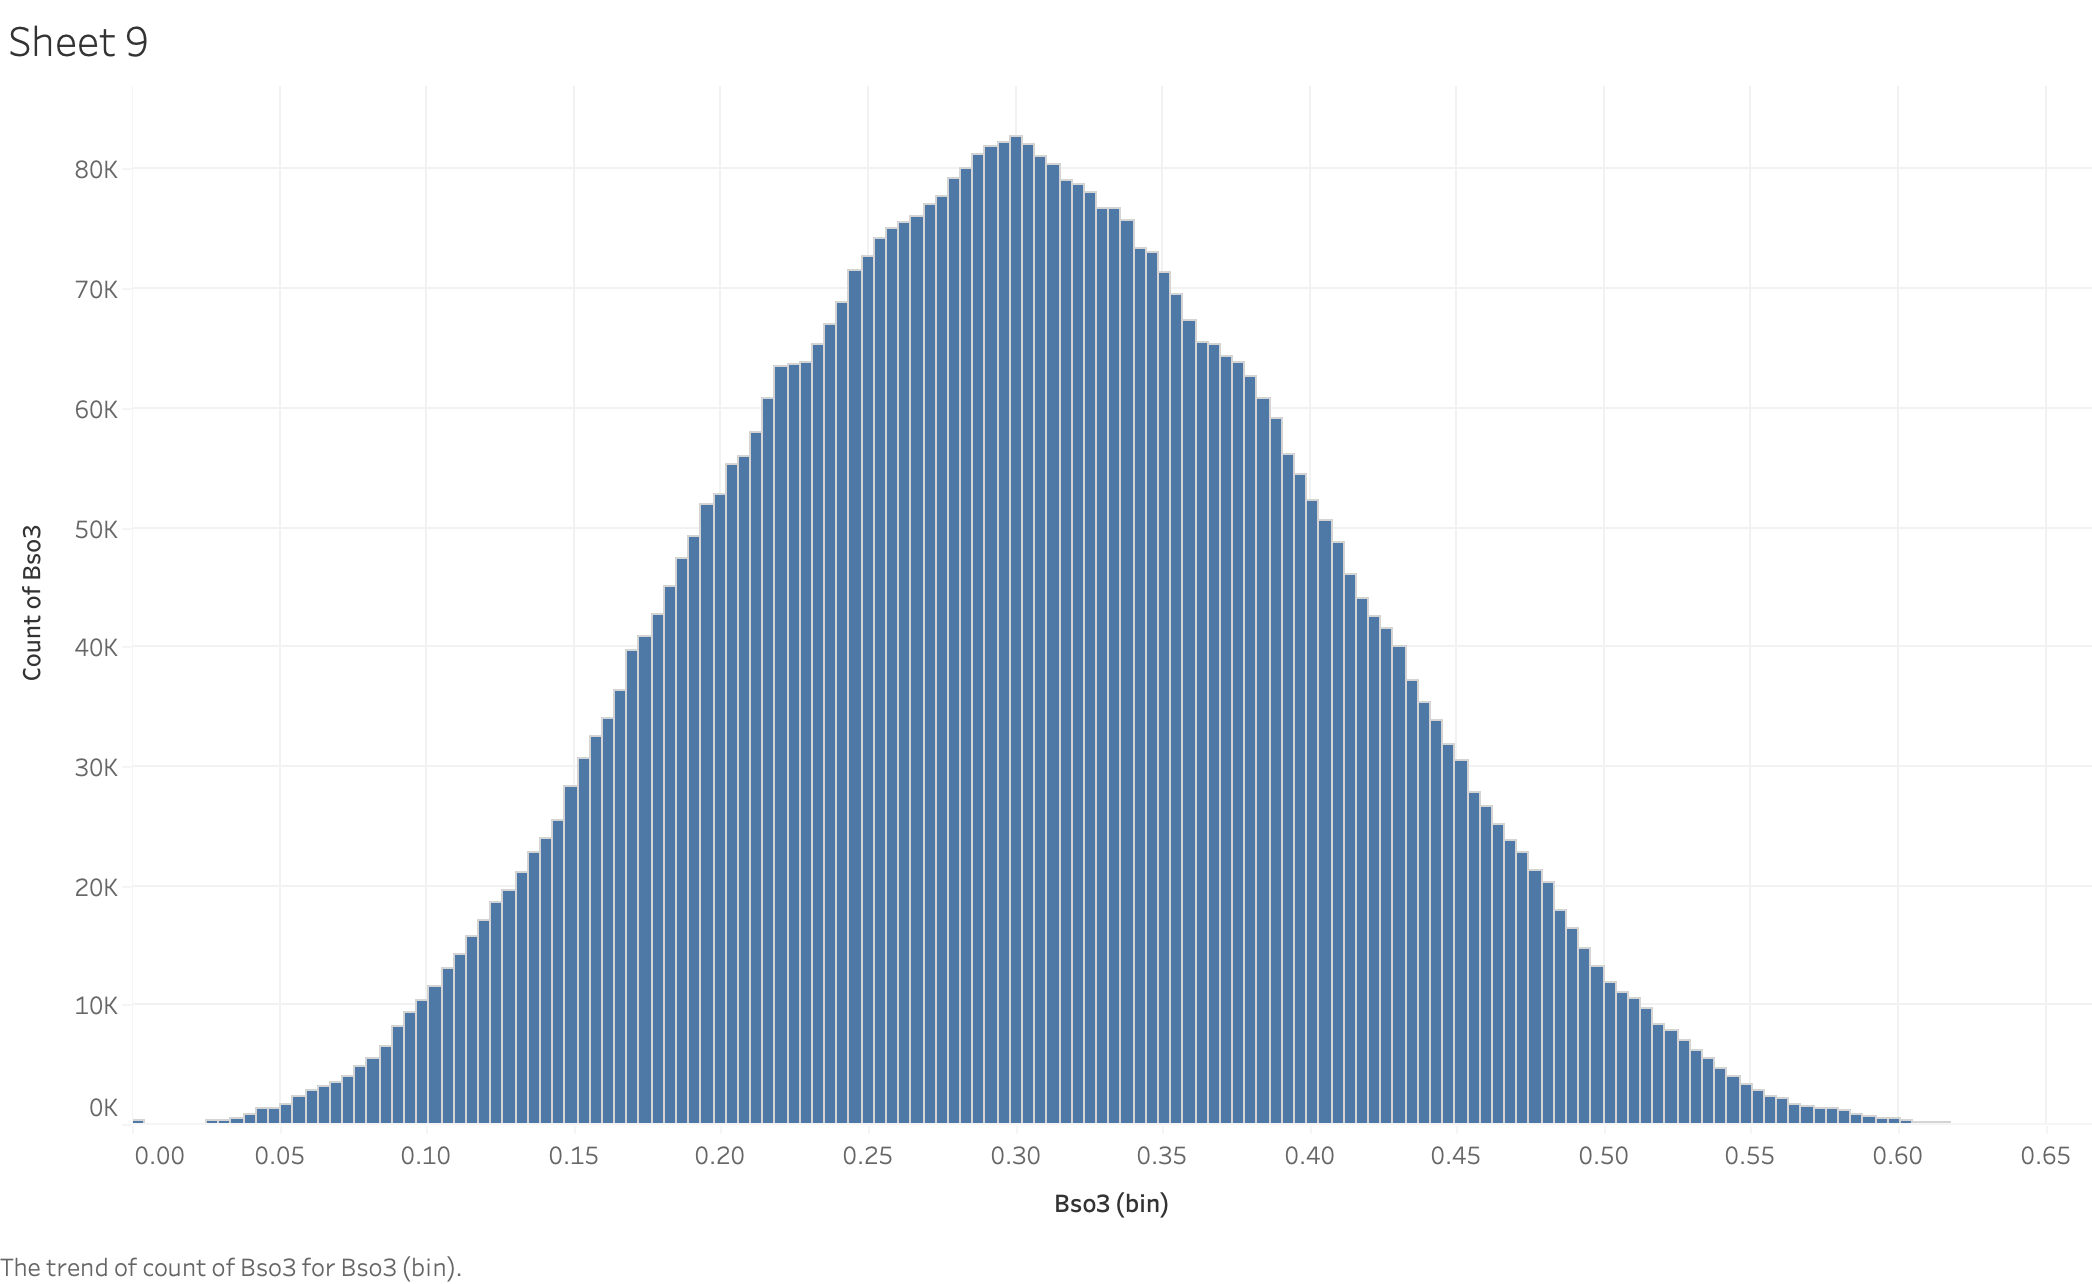

###Gráfica Ced1
Se muestran datos con una distribución normal, con una pendiente que va disminuyendo a mayor medida de que los datos suben de valor.

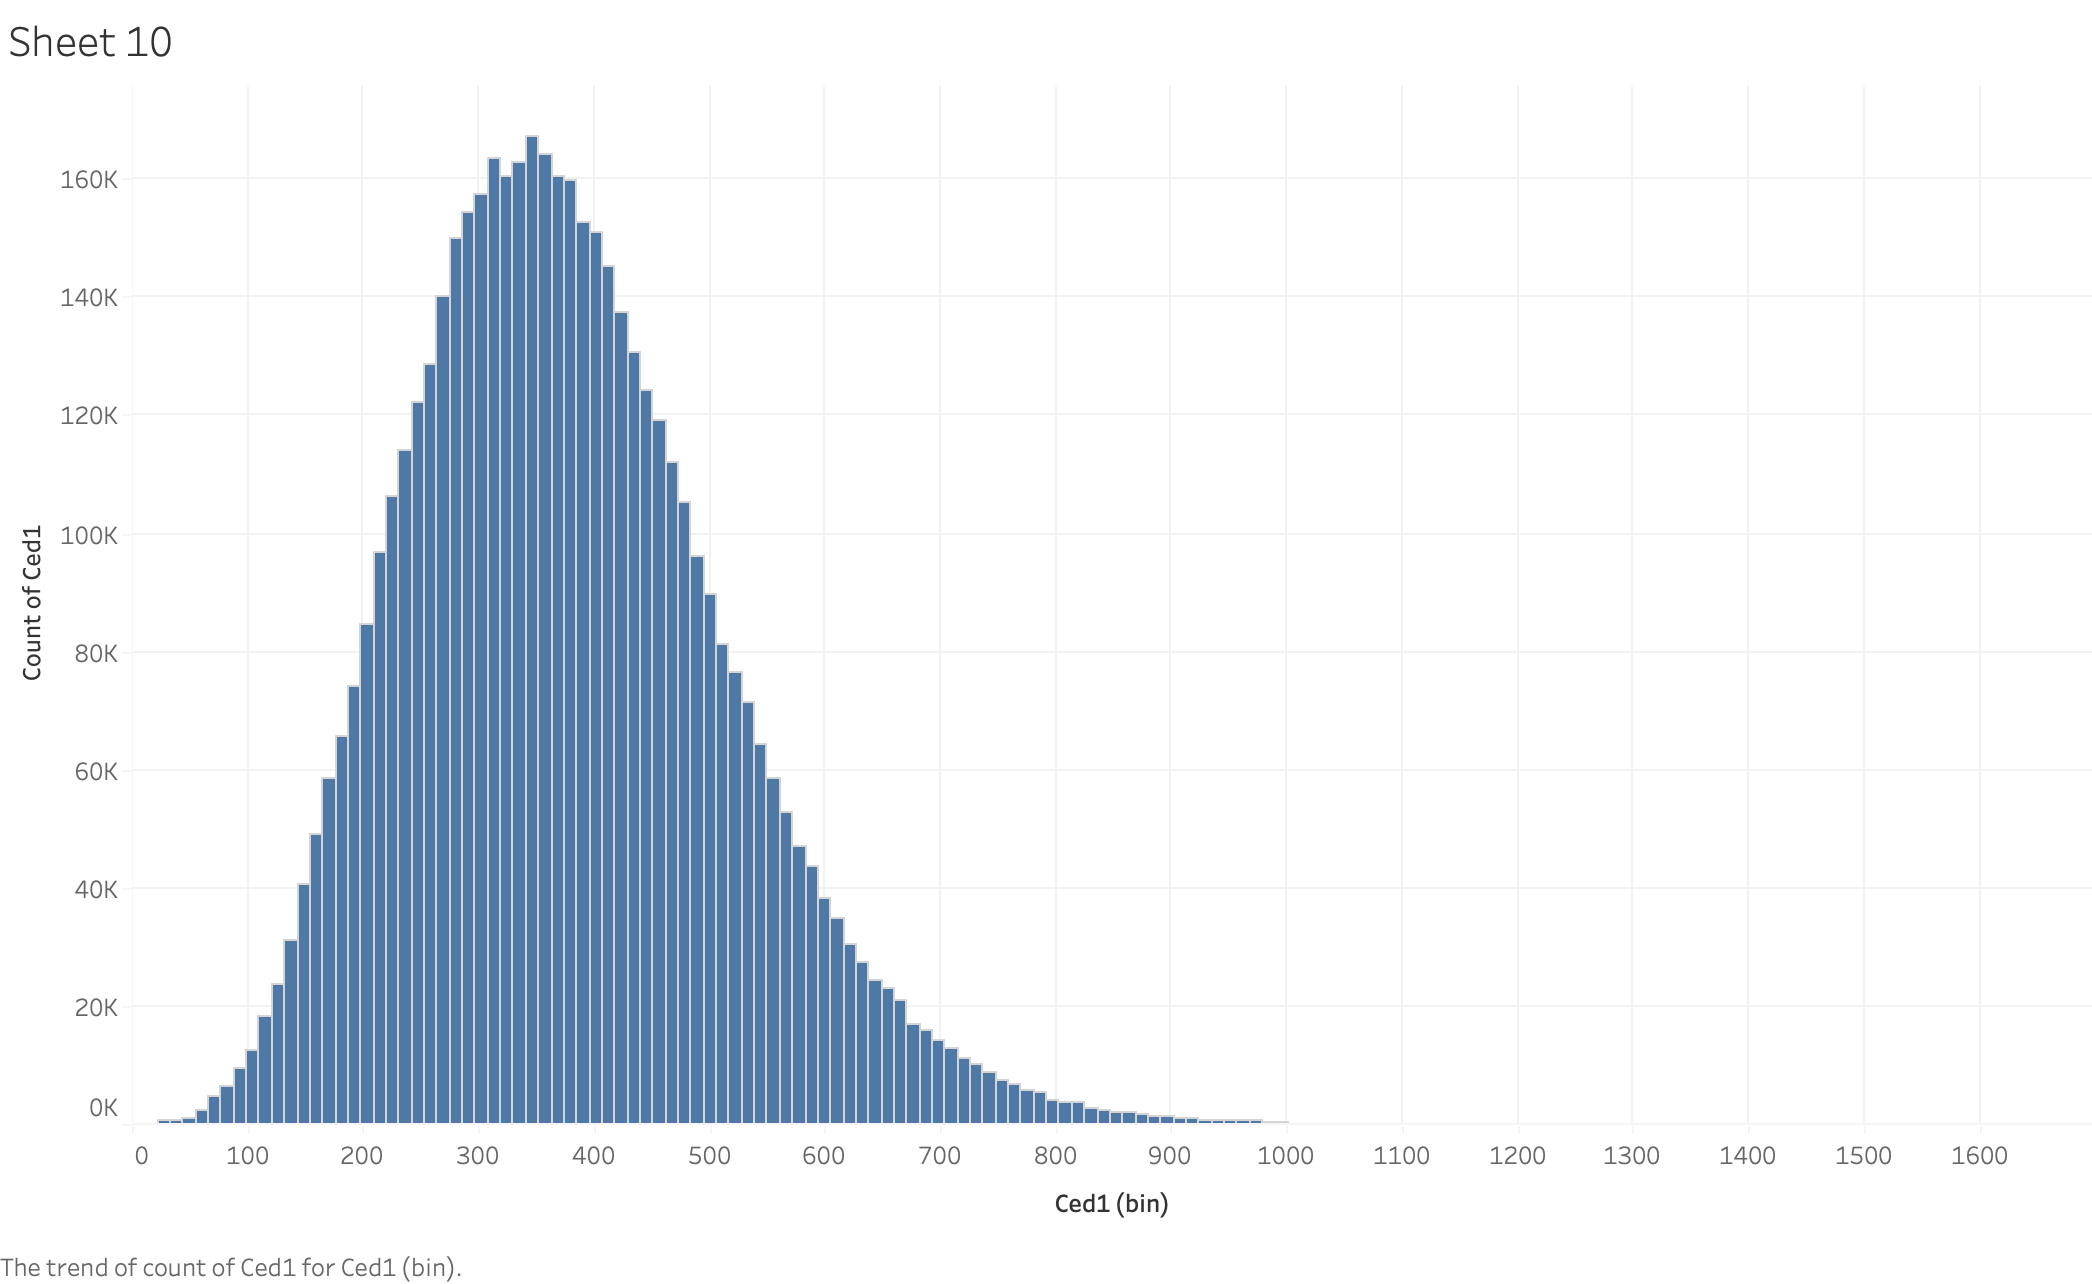

###Gráfica Cfo1
Se muestran datos con una distribución normal con valores tanto negativos como positivos, lo que podría resultar en un coeficiente negativo en el modelo.

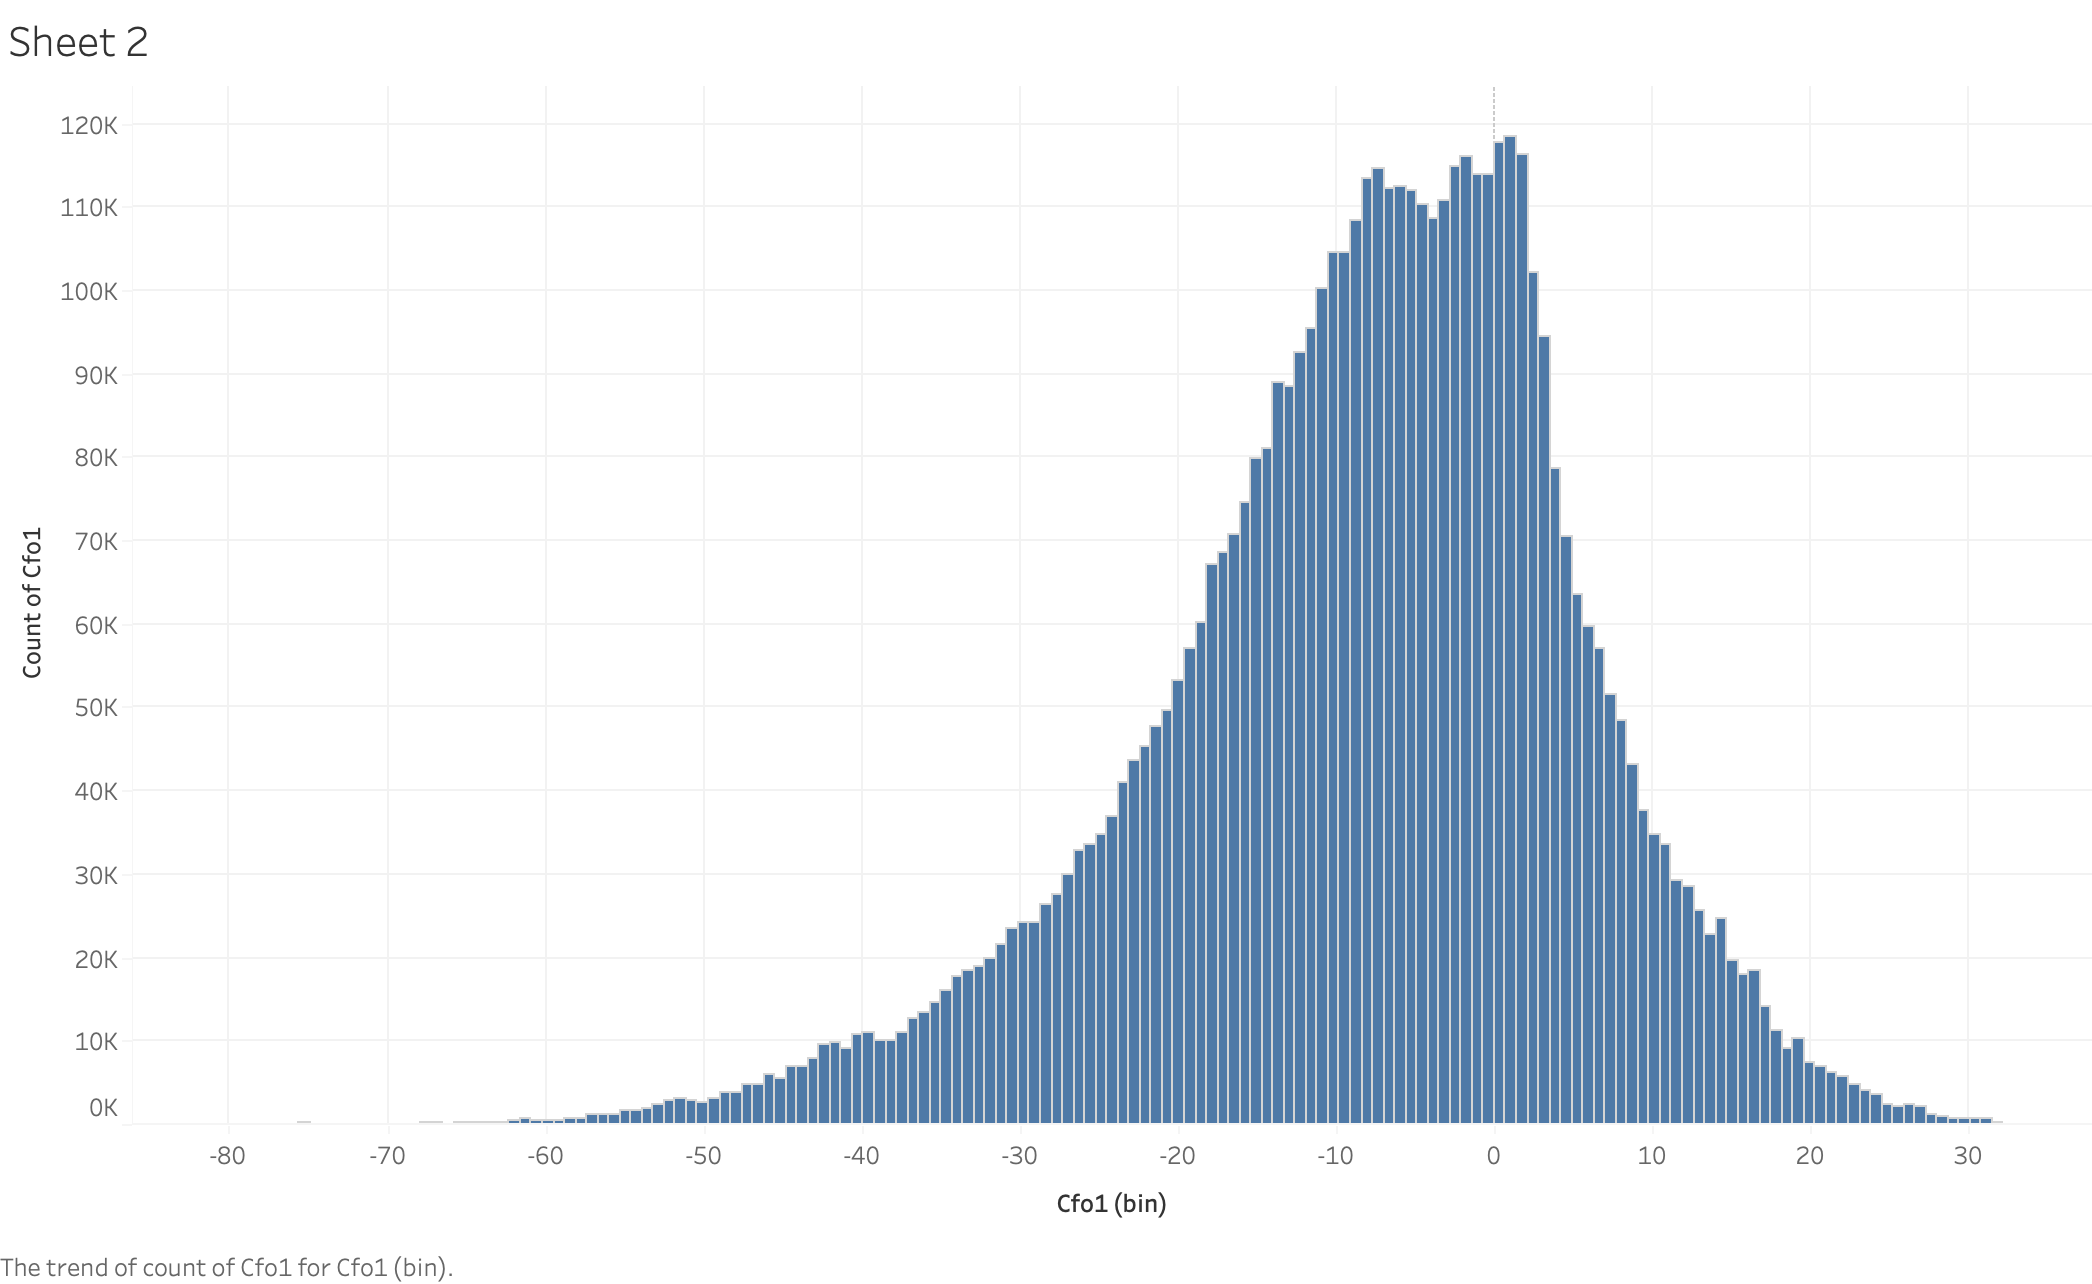

##Variable dependiente y elección del modelo
En este caso, se tomará como variable a predecir los datos recopilados por la lectura de telimetría catalogada como Cso1, la cual se puede observar que cuenta con una distribución normal.
Algo importante a mencionar es que el problema se puede tomar de diferentes maneras, ya que en este caso no se cuenta con demasiada información acerca de cada uno de los datos, además, se podría considerar tanto como un problema de series de tiempo respecto a una sola variable, como a una regresión lineal que considere diferentes datos, ahora bien, como se planteó desde el inicio con el análisis de los datos, se aprovecharán dichos elementos para construir un modelo de regresión lineal.

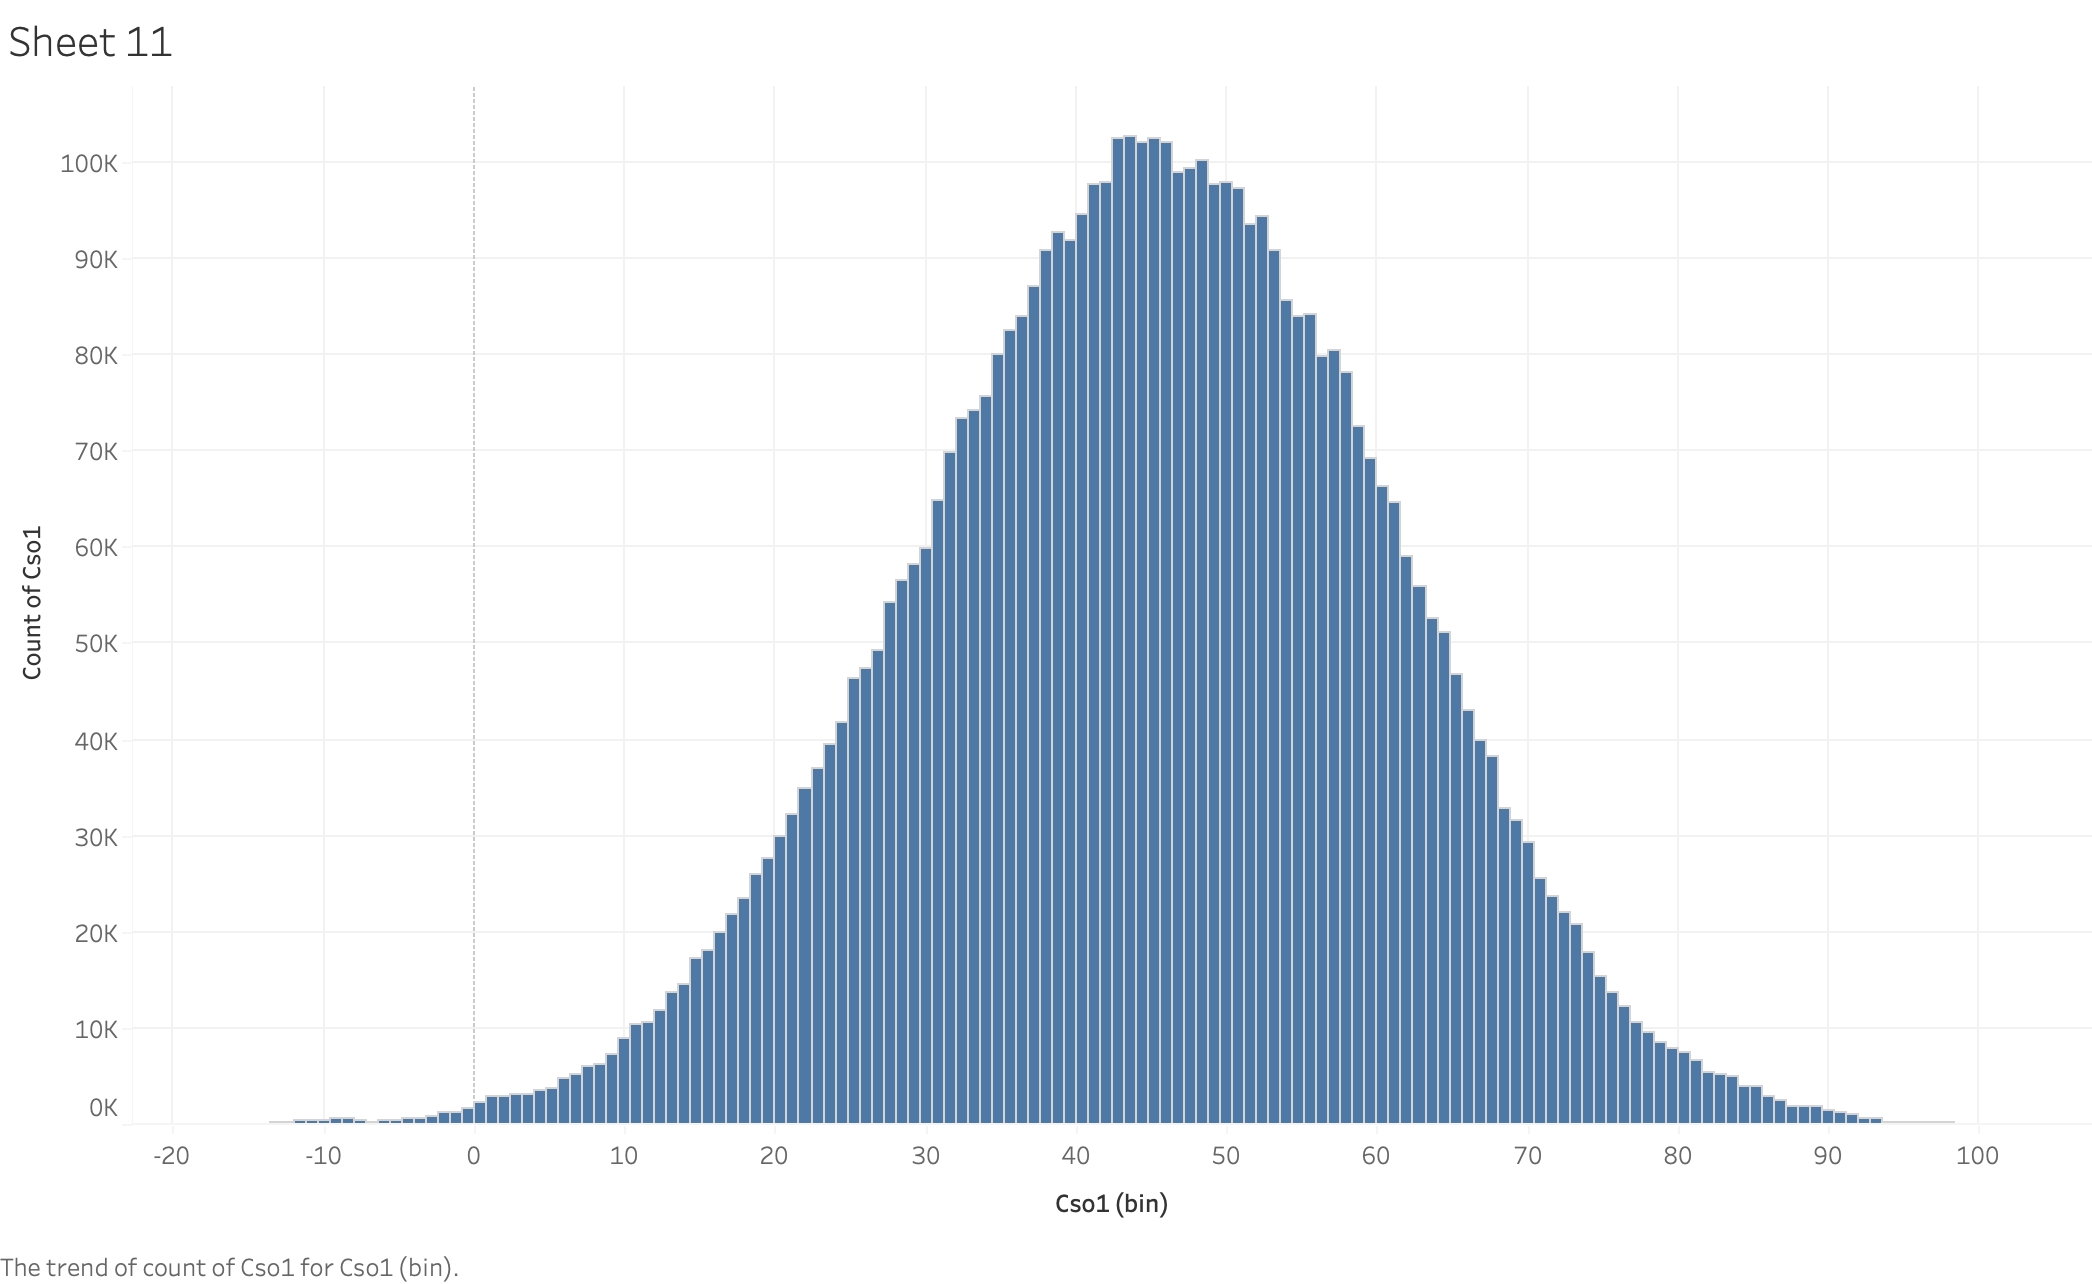

##Modelo

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

feature_cols = ["aimp", "amud", "arnd", "asin1", "asin2", "adfl",
                "bed1", "bed2", "bfo1", "bfo2", "bso1", "bso2",
                "bso3", "ced1", "cfo1", "adbrVec"]

if "features" in assembled_data.columns:
    assembled_data = assembled_data.drop("features")

# Configurar el VectorAssembler para combinar las características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(assembled_data)

# Dividir datos en conjuntos de entrenamiento y prueba (80% - 20%)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Configurar y entrenar el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="cso1")
lr_model = lr.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = lr_model.transform(test_data)

# Evaluar el modelo usando RMSE
evaluator = RegressionEvaluator(labelCol="cso1", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Paso 8: Mostrar los coeficientes y la intersección del modelo
print("Coeficientes:", lr_model.coefficients)
print("Intersección:", lr_model.intercept)

Root Mean Squared Error (RMSE): 0.4715245322567158
Coeficientes: [0.0011833326675255642,0.11977208650366339,0.01062651894208256,-0.33682186187199786,-0.8806812332426811,-0.5344004763732921,6.79720860516807e-05,0.0013634078795214442,-0.11415653475854329,1.0329312249482867,0.9739826671721278,-0.9557108029531652,1.5293595650603165,1.6247976928485138e-06,-0.09390123417694955,-1.226411144853274]
Intersección: 0.43854931201522424


* Root Mean Squared Error (RMSE): El valor de 0.47 indica el error promedio de las predicciones del modelo con respecto a los valores reales. Y debido a que la distribución de los datos de "Cso1" tienen un rango amplio (de -20 a 100 aproximadamente), un error de 0.47 es bastante bajo en comparación con el rango total de los valores.

* Intersección (Intercept): Este valor de 0.4385 representa la predicción del modelo cuando todas las variables independientes son cero.

##Evaluación del modelo
###Gráfica de predicciones
La gráfica muestra la relación entre los valores reales de "Cso1" y las predicciones del modelo. La línea roja representa la línea ideal donde las predicciones son exactamente iguales a los valores reales.

Se puede ver que los puntos están muy alineados a lo largo de esta línea, lo que indica que el modelo está haciendo predicciones muy precisas. La cercanía de los puntos a la línea ideal confirma que el error es bajo (como lo muestra el RMSE de 0.47), por lo que que el modelo tiene un buen desempeño al capturar la variación en los datos y para hacer predicciones.

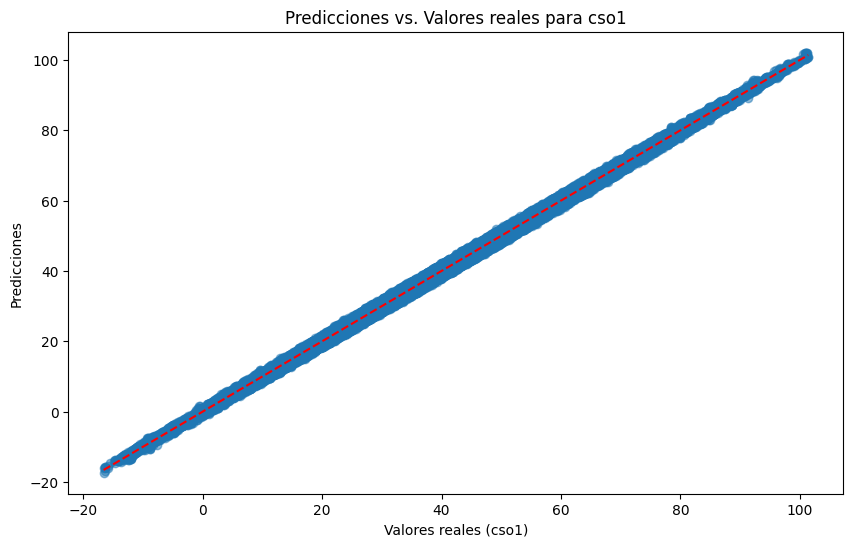

In [ ]:
import matplotlib.pyplot as plt

# Selecciona las columnas de predicción y valores reales
prediction_and_labels = predictions.select("prediction", "cso1").toPandas()

# Crea el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(prediction_and_labels["cso1"], prediction_and_labels["prediction"], alpha=0.5)
plt.xlabel("Valores reales (cso1)")
plt.ylabel("Predicciones")
plt.title("Predicciones vs. Valores reales para cso1")
plt.plot([min(prediction_and_labels["cso1"]), max(prediction_and_labels["cso1"])],
         [min(prediction_and_labels["cso1"]), max(prediction_and_labels["cso1"])],
         color='red', linestyle='--')  # Línea de referencia y=x
plt.show()

La gráfica muestra un gráfico de dispersión entre los valores reales de la variable cso1 (en el eje x) y las predicciones del modelo (en el eje y). La mayoría de los puntos se agrupan a lo largo de la línea de referencia roja, dicha linea representa la relación ideal y = x, lo que sugiere una alta correlación entre las predicciones y los valores reales. Indicando que el modelo tiene un rendimiento adecuado, ya que sus predicciones son muy cercanas a los valores reales.

Descargué las predicciones para realizar el gráfico en Tabelu

In [ ]:
prediction_and_labels = predictions.select("prediction", "cso1")

# Guarda las predicciones y valores reales en un archivo CSV
prediction_and_labels.toPandas().to_csv("/content/drive/MyDrive/TC3006C-InteligenciaAritificialAvanzada/PySpark project/predictions_vs_actuals.csv", index=False)

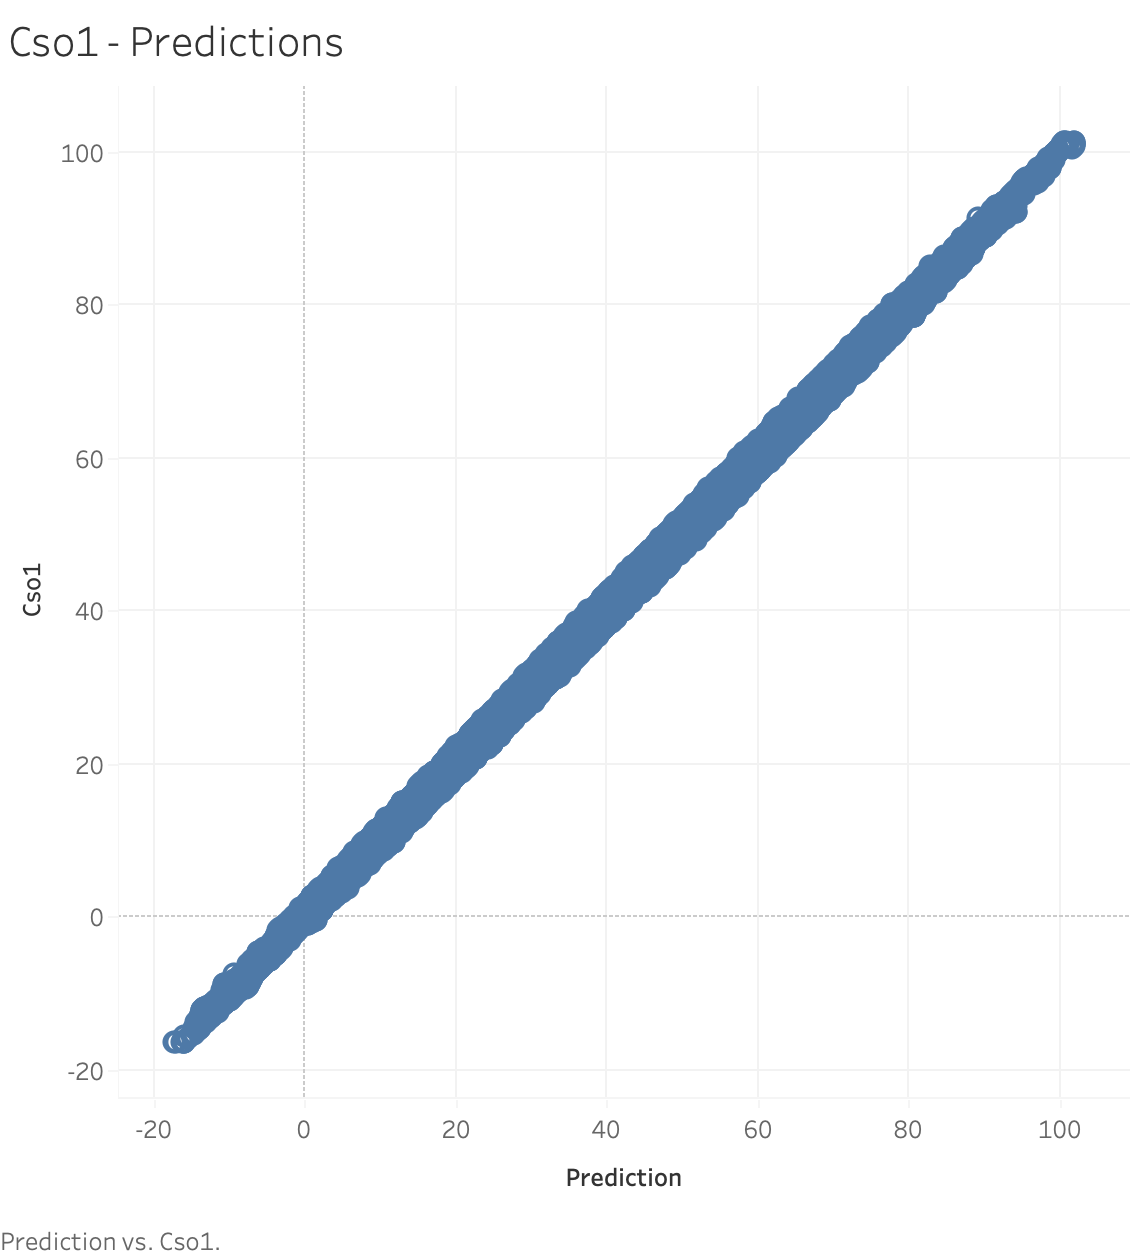

##Métricas adicionales

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluador para R²

evaluator_r2 = RegressionEvaluator(labelCol="cso1", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Evaluador para MAE
evaluator_mae = RegressionEvaluator(labelCol="cso1", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

print(f"RMSE: {rmse}, R²: {r2}, MAE: {mae}")


RMSE: 0.4715245322567158, R²: 0.9990856661469891, MAE: 0.3700482512006151


El R cuadrado está muy cerca de 1, lo que significa que el modelo explica el 99.91% de la variabilidad en los datos de "Cso1". Esto sugiere que el modelo se ajusta extremadamente bien a los datos y que las predicciones son muy precisas. Esto se debe, entre varias cosas, a que los datos se encuentran muy bien registrados y con una buena distribución y correlación.

El MAE indica el error promedio en las predicciones, y en este caso, un valor de 0.37 es bastante bajo, lo que significa que, en promedio, las predicciones del modelo difieren de los valores reales en aproximadamente 0.37 unidades. Esto refuerza que el modelo es preciso.

In [ ]:
#spark.stop()

##Evidencia de Tableau


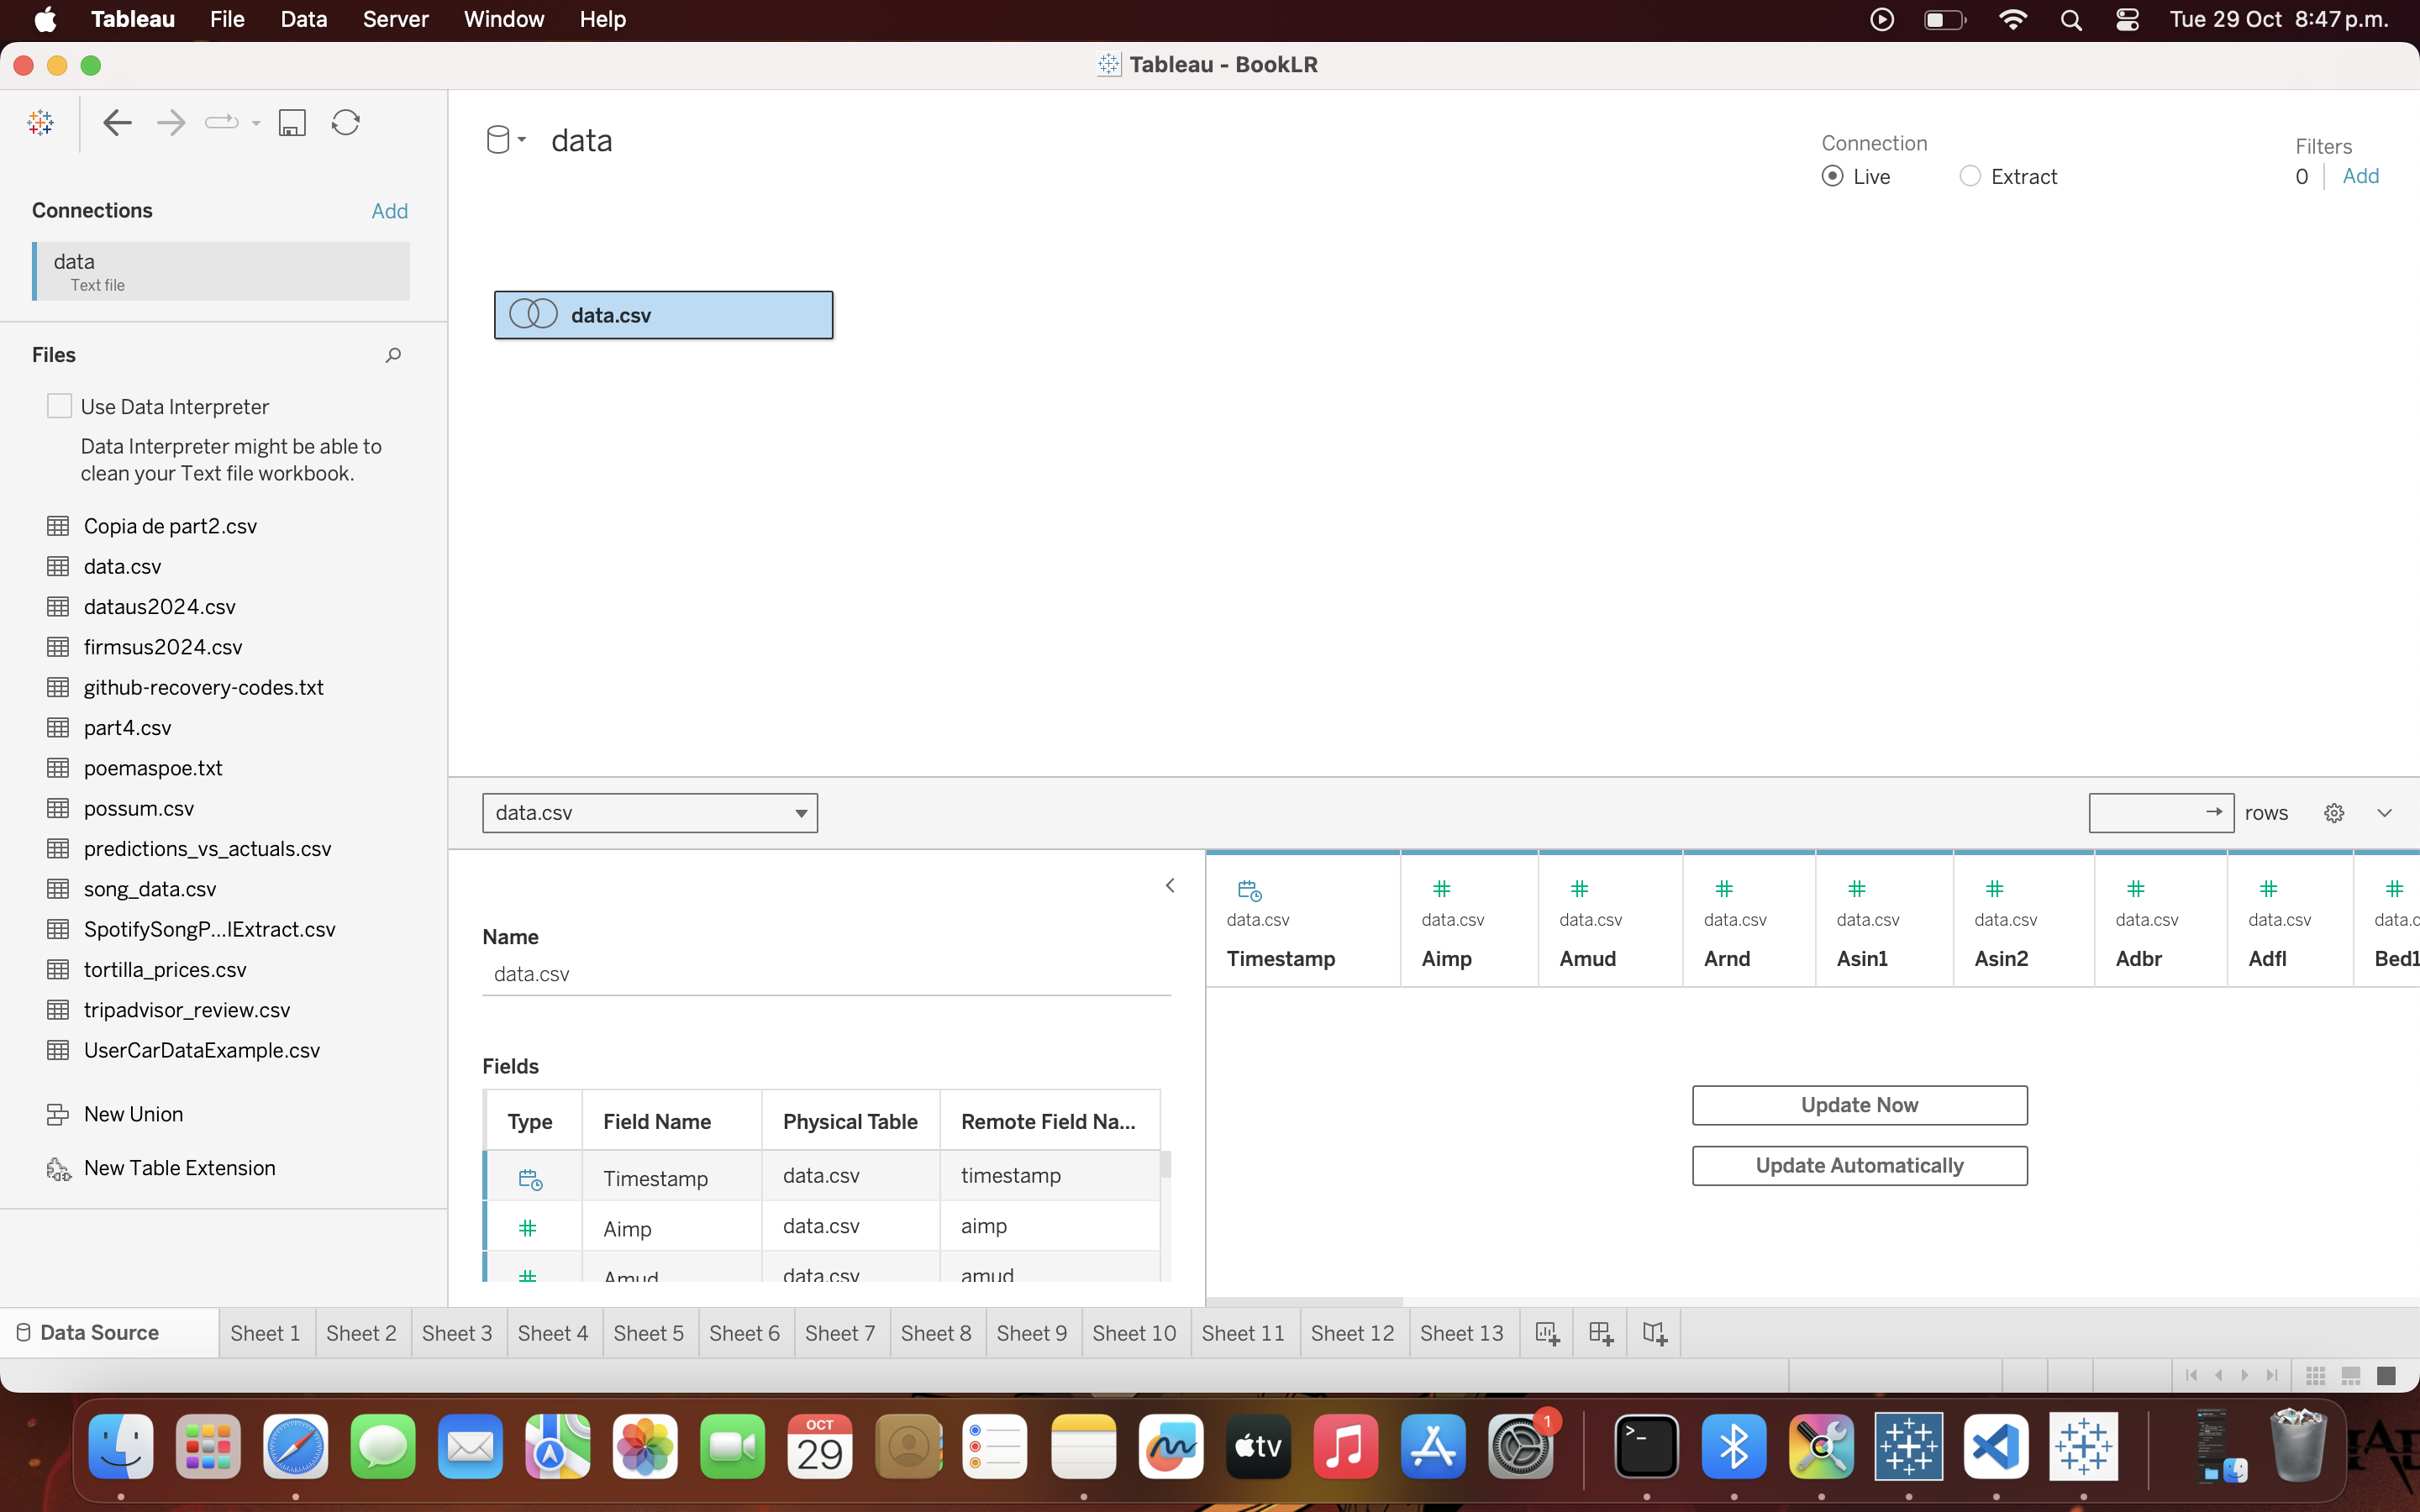